<a href="https://colab.research.google.com/github/Vorlde/-WQU-MScFE-Capstone-Project/blob/main/Trading_baseline_ver.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
! pip install dill
! pip install statsmodels
!pip install hurst
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller as ADF_test
import matplotlib.pyplot as plt

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 3.9 MB/s eta 0:00:00


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
from tensorflow.keras.models import load_model

# Define the file path for saving the model
file_path = "/content/drive/My Drive/Model/hedge_ratio_model.h5"

# To load the model later
loaded_model = load_model(file_path)


In [4]:
import pandas as pd
import numpy as np
from datetime import datetime, timedelta


from sklearn.cluster import KMeans, DBSCAN
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn import preprocessing

from statsmodels.tsa.stattools import coint

from scipy import stats

import lzma
import dill as pickle

def save_pickle(path,obj):
    with lzma.open(path,"wb") as fp:
        pickle.dump(obj,fp)

def load_pickle(path):
    with lzma.open(path,"rb") as fp:
        file = pickle.load(fp)
    return file

def clean_data(ticker_dfs,tickers):
    intraday_range = ticker_dfs[tickers[0]].index
    for inst in tickers:
        ticker_dfs[inst] = ticker_dfs[inst].reindex(intraday_range)
    closes = []

    for tk in tickers:
        close = ticker_dfs[tk].close
        closes.append(close)

    pricing = pd.concat(closes,axis = 1)
    pricing.columns = tickers

    return pricing




def get_pca_features(ret_df,N_PRIN_COMPONENTS =10):

    pca = PCA(n_components=N_PRIN_COMPONENTS)
    pca.fit(ret_df)

    # Extract factor loadings
    factor_loadings = pca.components_.T  # Transpose the components matrix

    # Create a DataFrame with the correct orientation
    factor_loadings_df = pd.DataFrame(factor_loadings, index=ret_df.columns, columns=[f'Factor {i+1}' for i in range(N_PRIN_COMPONENTS)])

    X = preprocessing.StandardScaler().fit_transform(pca.components_.T)

    return X

def create_clusters(X,index):
    clf = DBSCAN(eps=1.5, min_samples=3)

    print(clf)

    clf.fit(X)
    labels = clf.labels_
    n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
    print("\nClusters discovered: %d" % n_clusters_)

    clustered = clf.labels_

    clustered_series = pd.Series(index=index, data=clustered.flatten())
    clustered_series = clustered_series[clustered_series != -1]

    return clustered_series


def find_cointegrated_pairs(data, significance=0.05):
    # This function is from https://www.quantopian.com/lectures/introduction-to-pairs-trading
    n = data.shape[1]
    score_matrix = np.zeros((n, n))
    pvalue_matrix = np.ones((n, n))
    keys = data.keys()
    pairs = []
    for i in range(n):
        for j in range(i+1, n):
            S1 = data[keys[i]]
            S2 = data[keys[j]]
            result = coint(S1, S2)
            score = result[0]
            pvalue = result[1]
            score_matrix[i, j] = score
            pvalue_matrix[i, j] = pvalue
            if pvalue < significance:
                pairs.append((keys[i], keys[j]))
    return score_matrix, pvalue_matrix, pairs



def get_coint_pairs(prices,clustered_series):

    valid_tickers = clustered_series.index.intersection(prices.columns)
    clustered_series = clustered_series.loc[valid_tickers]

    CLUSTER_SIZE_LIMIT = 9999
    counts = clustered_series.value_counts()
    ticker_count_reduced = counts[(counts>1) & (counts<=CLUSTER_SIZE_LIMIT)]

    cluster_dict = {}
    for i, which_clust in enumerate(ticker_count_reduced.index):
        tickers = clustered_series[clustered_series == which_clust].index
        score_matrix, pvalue_matrix, pairs = find_cointegrated_pairs(
            prices[tickers]
        )
        cluster_dict[which_clust] = {}
        cluster_dict[which_clust]['score_matrix'] = score_matrix
        cluster_dict[which_clust]['pvalue_matrix'] = pvalue_matrix
        cluster_dict[which_clust]['pairs'] = pairs

    pairs = []
    for clust in cluster_dict.keys():
        pairs.extend(cluster_dict[clust]['pairs'])

    return pairs


def get_data():
    data_path = "/content/drive/My Drive/constituents.csv"
    dfs_path = "/content/drive/My Drive/new_dfs.obj"

    ticker_dfs = load_pickle(dfs_path)
    snp_data = pd.read_csv(data_path)
    tickers = []

    for i in range(499):
      tickers.append(snp_data.Symbol[i])

    tickers.remove("BF.B")
    tickers.remove("BRK.B")
    tickers.remove("CPAY")
    tickers.remove("DAY")
    tickers.remove("GEV")
    tickers.remove("SOLV")

    return tickers,ticker_dfs

In [5]:
tickers,ticker_dfs = get_data()

In [6]:
def generate_trading_data_blocks(df, month, year):
    if month == 12:
        month = 1
        year += 1
    else:
        month += 1

    next_month_data = df[(df.index.year == year) & (df.index.month == month)]
    return next_month_data


def find_cointegrated_pairs(data):
    # Placeholder function for cointegration check
    # Implement the actual cointegration logic here
    score_matrix = np.zeros((data.shape[1], data.shape[1]))
    pvalue_matrix = np.ones((data.shape[1], data.shape[1]))
    pairs = []

    for i in range(data.shape[1]):
        for j in range(i+1, data.shape[1]):
            result = sm.tsa.coint(data.iloc[:, i], data.iloc[:, j])
            score = result[0]
            pvalue = result[1]
            score_matrix[i, j] = score
            pvalue_matrix[i, j] = pvalue
            if pvalue < 0.05:  # Cointegrated pair found
                pairs.append((data.columns[i], data.columns[j]))

    return score_matrix, pvalue_matrix, pairs


def calculate_monthly_clusters(monthly_data):
    """
    Calculate clusters for the given month.

    """
    ret_df = monthly_data.pct_change().round(4).fillna(0)
    X = get_pca_features(ret_df)
    clustered_series = create_clusters(X, ret_df.columns)

    return clustered_series


def yield_monthly_data(data):
    for (year, month), monthly_data in data.groupby([data.index.year, data.index.month]):
        yield year, month, monthly_data

In [7]:

import statsmodels.api as sm
from hurst import compute_Hc  # Assuming you have a function to compute the Hurst exponent
from statsmodels.tools.tools import add_constant
from scipy.stats import skew, kurtosis

def add_stationary(spread_normalized):

    rolling_volatility = spread_normalized[:500].rolling(window=10).std()
    hurst_exponent = compute_Hc(spread_normalized[:500])[0]  # Hurst exponent

    skewness = skew(spread_normalized[:500])
    kurtosis_value = kurtosis(spread_normalized[:500])


    # Ensure spread_lagged starts from the second element to align with spread_diff which starts from the second element due to differencing and shifting
    spread_lagged = spread_normalized.shift(1).dropna()
    spread_diff = spread_normalized.diff().dropna()  # First difference to get spread_diff

    # Make sure indices are aligned by reindexing spread_diff to match spread_lagged
    spread_diff = spread_diff.reindex(spread_lagged.index)
    spread_diff += 1e-8

    # Now perform your regression with aligned indices
    model = sm.OLS(np.log(np.abs(spread_diff)), add_constant(spread_lagged))
    result = model.fit()
    phi = result.params[0]


    spread_normalized = spread_normalized[:500]  # Normalized spread

    features_df = pd.DataFrame({
        'spread_normalized': spread_normalized,
        'rolling_volatility': rolling_volatility[:500],
        'hurst_exponent': np.repeat(hurst_exponent, rolling_volatility.shape[0]),
    })

    # Mean Reversion Speed calculated as the absolute value of phi
    mean_reversion_speed = np.abs(phi)

    # Calculate half-life from the decay factor
    half_life = -np.log(2) / np.log(np.abs(phi))


    features_df['half_life'] = np.repeat(half_life, len(features_df))
    features_df['mean_reversion_speed'] = np.repeat(mean_reversion_speed, len(features_df))
    features_df['skewness'] = np.repeat(skewness, len(features_df))
    features_df['kurtosis'] = np.repeat(kurtosis_value, len(features_df))

    return features_df




def process_pair(pair, prices):
    s1, s2 = pair

    datax = prices[s1]
    datay = prices[s2]

    # Calculate hedge ratio using the first 500 data points
    hedge_ratio = sm.OLS(datax[:500], sm.add_constant(datay[:500])).fit().params[1]

    # Calculate the spread based on the hedge ratio
    spread = datax - hedge_ratio * datay

    # Calculate mean and standard deviation using the first 500 data points
    initial_mean = spread[:500].mean()
    initial_std = spread[:500].std()

    # Create a DataFrame with the calculated columns
    df = pd.DataFrame({
        'datax': datax,
        'datay': datay,
        'hedge_ratio': hedge_ratio,
        'spread': spread,
        'rolling_mean': initial_mean,
        'rolling_std': initial_std
    })

    # Normalized spread
    spread_normalized = (spread - initial_mean) / initial_std

    # Plotting the normalized spread along with mean and ±2 std lines
    plt.figure(figsize=(15, 7))
    spread_normalized = spread_normalized.reset_index(drop=True)
    plt.title(f'Z-Scores for {s1} and {s2} Across Training Period')
    spread_normalized.plot(label='Normalized Spread')
    plt.axhline(y=0, color='black', linestyle='--', label='Mean')
    plt.axhline(y=2, color='red', linestyle='--', label='+2 Std Dev')
    plt.axhline(y=-2, color='green', linestyle='--', label='-2 Std Dev')
    plt.legend()
    plt.show()

    return df



import statsmodels.api as sm

def calculate_hedge_ratio(x, y):
    x = sm.add_constant(x)  # Adding a constant term for the intercept
    model = sm.OLS(y, x).fit()
    return model.params[1]  # Return

def process_pair(pair, prices, window=100):
    s1, s2 = pair
    datax = prices[s1]
    datay = prices[s2]

    hedge_ratios = []
    for start in range(len(datax) - window + 1):
        end = start + window
        x_window = datax[start:end]
        y_window = datay[start:end]
        hedge_ratio = calculate_hedge_ratio(x_window, y_window)
        hedge_ratios.append(hedge_ratio)

    hedge_ratios = pd.Series(hedge_ratios, index=datax.index[window-1:])
    hedge_ratios = hedge_ratios.reindex(datax.index).fillna(method='bfill')

    spread = datax - hedge_ratios * datay
    rolling_mean = spread.rolling(window=window).mean()
    rolling_std = spread.rolling(window=window).std()
    upper_threshold_level = rolling_mean + 2 * rolling_std
    lower_threshold_level = rolling_mean - 2 * rolling_std

    # Calculate spread
    spread = datax - hedge_ratios * datay

    # Calculate rolling mean and rolling standard deviation
    rolling_mean = spread.rolling(window=window).mean()
    rolling_std = spread.rolling(window=window).std()

    # Calculate upper and lower threshold levels
    upper_threshold_level = rolling_mean + 2 * rolling_std
    lower_threshold_level = rolling_mean - 2 * rolling_std

    # Create DataFrame
    result_df = pd.DataFrame({
        's1': datax,
        's2': datay,
        'spread': spread,
        'hedge_ratios': hedge_ratios,
        'rolling_mean': rolling_mean,
        'upper_threshold_level': upper_threshold_level,
        'lower_threshold_level': lower_threshold_level
    })

    return result_df



In [8]:
# tickers,ticker_dfs = get_data()
intraday_dfs = ticker_dfs.copy()
prices = clean_data(intraday_dfs, tickers)

In [9]:
import numpy as np
import pandas as pd

class TradingAgent:
    def __init__(self, initial_capital=100000):
        self.initial_capital = initial_capital
        self.per_pair_capital = initial_capital

    def calculate_hedge_ratio(self, x, y):
        x = sm.add_constant(x)  # Adding a constant term for the intercept
        model = sm.OLS(y, x).fit()
        return model.params[1]  # Return the coefficient of x, which is the hedge ratio

    def process_pair(self, pair, prices, window=100):
        s1, s2 = pair
        datax = prices[s1]
        datay = prices[s2]

        hedge_ratios = []
        for start in range(len(datax) - window + 1):
            end = start + window
            x_window = datax[start:end]
            y_window = datay[start:end]
            hedge_ratio = self.calculate_hedge_ratio(x_window, y_window)
            hedge_ratios.append(hedge_ratio)

        hedge_ratios = pd.Series(hedge_ratios, index=datax.index[window-1:])
        hedge_ratios = hedge_ratios.reindex(datax.index).fillna(method='bfill')

        spread = datax - hedge_ratios * datay
        rolling_mean = spread.rolling(window=window).mean()
        rolling_std = spread.rolling(window=window).std()
        upper_threshold_level = rolling_mean + 2 * rolling_std
        lower_threshold_level = rolling_mean - 2 * rolling_std

        result_df = pd.DataFrame({
            's1': datax,
            's2': datay,
            'spread': spread,
            'hedge_ratios': hedge_ratios,
            'rolling_mean': rolling_mean,
            'upper_threshold_level': upper_threshold_level,
            'lower_threshold_level': lower_threshold_level
        })

        result_df['returns'] = 0.0
        result_df['returns_pct'] = 0.0
        result_df['capital'] = self.initial_capital
        result_df['action'] = np.nan

        return result_df

    def trade(self, result_df):
        capital = self.initial_capital
        positions = 0
        entry_spread = 0
        entry_s1 = 0
        entry_s2 = 0
        entry_qty_s1 = 0
        entry_qty_s2 = 0
        last_capital_update_index = 0
        stop_loss_threshold = 0.01  # 1% stop loss

        result_df['returns'] = 0.0
        result_df['returns_pct'] = 0.0
        result_df['capital'] = capital
        result_df['cap_ret'] = 0.0

        for i in range(1, len(result_df)):  # Start from the second row
            # Update capital for all rows till the current row
            if i > last_capital_update_index:
                result_df.loc[result_df.index[last_capital_update_index:i], 'capital'] = capital

            # Calculate the required capital to trade one pair
            hedge_ratio = abs(result_df['hedge_ratios'].iloc[i])
            required_capital_per_pair = (result_df['s1'].iloc[i] + hedge_ratio * result_df['s2'].iloc[i])

            # Calculate the maximum quantity that can be traded based on available capital
            max_qty = self.per_pair_capital // required_capital_per_pair

            if positions == 0:
                if result_df['spread'].iloc[i] > result_df['upper_threshold_level'].iloc[i]:
                    positions = -1  # Sell position
                    entry_spread = result_df['spread'].iloc[i]
                    entry_s1 = result_df['s1'].iloc[i]
                    entry_s2 = result_df['s2'].iloc[i]
                    entry_qty_s1 = max_qty
                    entry_qty_s2 = max_qty * hedge_ratio
                    result_df.at[result_df.index[i], 'action'] = 'Sell'
                    last_capital_update_index = i
                elif result_df['spread'].iloc[i] < result_df['lower_threshold_level'].iloc[i]:
                    positions = 1  # Buy position
                    entry_spread = result_df['spread'].iloc[i]
                    entry_s1 = result_df['s1'].iloc[i]
                    entry_s2 = result_df['s2'].iloc[i]
                    entry_qty_s1 = max_qty
                    entry_qty_s2 = max_qty * hedge_ratio
                    result_df.at[result_df.index[i], 'action'] = 'Buy'
                    last_capital_update_index = i

            elif positions == -1:
                if result_df['spread'].iloc[i] <= result_df['rolling_mean'].iloc[i]:
                    # Calculate returns for sell position
                    returns = (entry_qty_s1 * (entry_s1 - result_df['s1'].iloc[i]) -
                               entry_qty_s2 * (result_df['s2'].iloc[i] - entry_s2))
                    returns_pct = returns / required_capital_per_pair
                    capital += returns
                    result_df.at[result_df.index[i], 'returns'] = returns
                    result_df.at[result_df.index[i], 'returns_pct'] = returns_pct
                    result_df.at[result_df.index[i], 'capital'] = capital
                    result_df.at[result_df.index[i], 'action'] = 'Close Sell'
                    positions = 0  # Close position
                    last_capital_update_index = i
                else:
                    # Check stop loss for sell position
                    loss = (entry_qty_s1 * (result_df['s1'].iloc[i] - entry_s1) +
                            entry_qty_s2 * (entry_s2 - result_df['s2'].iloc[i]))
                    if loss >= stop_loss_threshold * self.per_pair_capital:
                        capital -= loss
                        returns_pct = -loss / required_capital_per_pair
                        result_df.at[result_df.index[i], 'returns'] = -loss
                        result_df.at[result_df.index[i], 'returns_pct'] = returns_pct
                        result_df.at[result_df.index[i], 'capital'] = capital
                        result_df.at[result_df.index[i], 'action'] = 'Stop Loss Sell'
                        positions = 0  # Close position due to stop loss
                        last_capital_update_index = i

            elif positions == 1:
                if result_df['spread'].iloc[i] >= result_df['rolling_mean'].iloc[i]:
                    # Calculate returns for buy position
                    returns = (entry_qty_s1 * (result_df['s1'].iloc[i] - entry_s1) +
                               entry_qty_s2 * (result_df['s2'].iloc[i] - entry_s2))
                    returns_pct = returns / required_capital_per_pair
                    capital += returns
                    result_df.at[result_df.index[i], 'returns'] = returns
                    result_df.at[result_df.index[i], 'returns_pct'] = returns_pct
                    result_df.at[result_df.index[i], 'capital'] = capital
                    result_df.at[result_df.index[i], 'action'] = 'Close Buy'
                    positions = 0  # Close position
                    last_capital_update_index = i
                else:
                    # Check stop loss for buy position
                    loss = (entry_qty_s1 * (entry_s1 - result_df['s1'].iloc[i]) +
                            entry_qty_s2 * (entry_s2 - result_df['s2'].iloc[i]))
                    if loss >= stop_loss_threshold * self.per_pair_capital:
                        capital -= loss
                        returns_pct = -loss / required_capital_per_pair
                        result_df.at[result_df.index[i], 'returns'] = -loss
                        result_df.at[result_df.index[i], 'returns_pct'] = returns_pct
                        result_df.at[result_df.index[i], 'capital'] = capital
                        result_df.at[result_df.index[i], 'action'] = 'Stop Loss Buy'
                        positions = 0  # Close position due to stop loss
                        last_capital_update_index = i

        # Update capital for the remaining rows
        result_df.loc[result_df.index[last_capital_update_index:], 'capital'] = capital

        # Calculate cumulative return on initial capital
        result_df['cap_ret'] = result_df['capital'] / self.initial_capital - 1

        return result_df


    def visualize_spread(self, result_df):
        plt.figure(figsize=(14, 7))

        plt.plot(result_df.index, result_df['spread'], label='Spread')
        plt.plot(result_df.index, result_df['rolling_mean'], label='Rolling Mean', linestyle='--')
        plt.plot(result_df.index, result_df['upper_threshold_level'], label='Upper Threshold', linestyle='--')
        plt.plot(result_df.index, result_df['lower_threshold_level'], label='Lower Threshold', linestyle='--')

        plt.fill_between(result_df.index, result_df['upper_threshold_level'], result_df['lower_threshold_level'], color='grey', alpha=0.3)

        # Add markers for actions
        buys = result_df[result_df['action'] == 'Buy']
        sells = result_df[result_df['action'] == 'Sell']
        close_buys = result_df[result_df['action'] == 'Close Buy']
        close_sells = result_df[result_df['action'] == 'Close Sell']

        plt.scatter(buys.index, buys['spread'] + 0.02, color='green', marker='^', s=100, label='Buy')  # Offset buys
        plt.scatter(sells.index, sells['spread'] - 0.02, color='red', marker='v', s=100, label='Sell')  # Offset sells
        plt.scatter(close_buys.index, close_buys['spread'], color='black', marker='o', s=100, label='Close Buy')
        plt.scatter(close_sells.index, close_sells['spread'], color='black', marker='x', s=100, label='Close Sell')

        plt.title('Spread with Rolling Mean and Threshold Levels')
        plt.xlabel('Time')
        plt.ylabel('Spread')
        plt.legend()
        plt.grid(True)
        plt.show()


    def calculate_metrics(self, result_df):
        # Filter out the rows where trades were closed
        closed_trades = result_df[result_df['action'].isin(['Close Buy', 'Close Sell', 'Stop Loss Buy', 'Stop Loss Sell'])]

        # Calculate the returns on closed trades
        trade_returns = closed_trades['returns_pct']

        # Calculate the average return per trade
        avg_trade_return = trade_returns.mean()

        # Calculate the standard deviation of returns per trade
        std_trade_return = trade_returns.std()

        # Calculate the Sharpe ratio
        sharpe_ratio = (avg_trade_return / std_trade_return) * np.sqrt(252)  # Assuming 252 trading days in a year

        # Calculate cumulative returns
        cumulative_return = result_df['cap_ret'].iloc[-1]

        metrics = {
            'Average Trade Return': avg_trade_return,
            'Standard Deviation of Trade Returns': std_trade_return,
            'Sharpe Ratio': sharpe_ratio,
            'Cumulative Return': cumulative_return
        }

        return metrics





Clustering for 3 2023
DBSCAN(eps=1.5, min_samples=3)

Clusters discovered: 6
0 ('MMM', 'BAC')


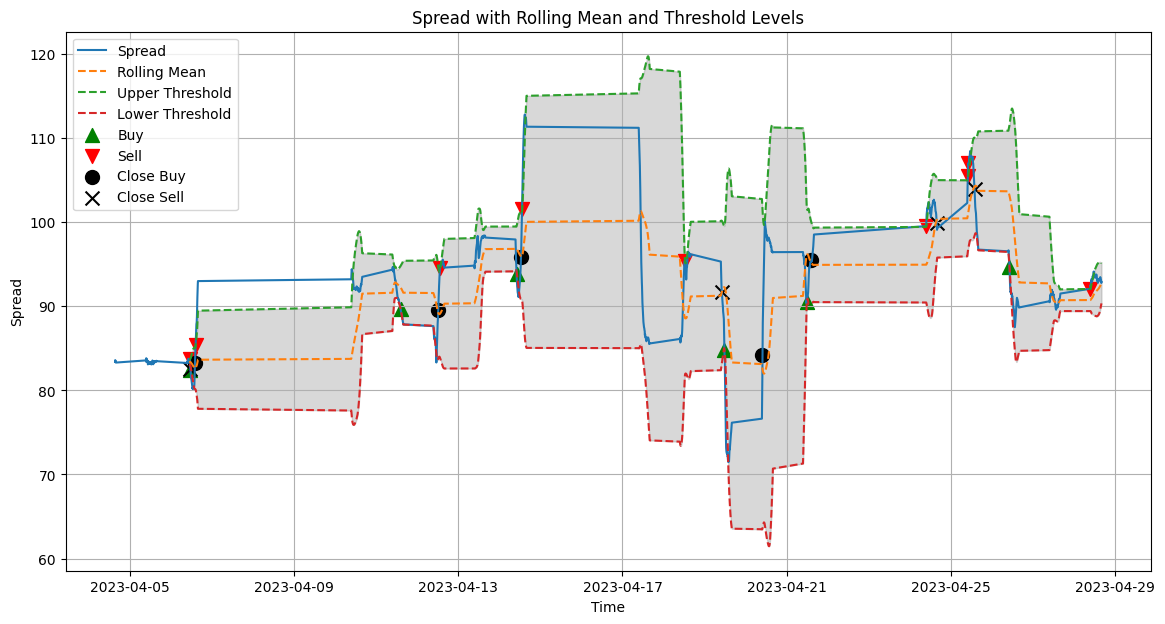

Trade Metrics:
Average Trade Return: -2.5780945461279754
Standard Deviation of Trade Returns: 8.931245260648687
Sharpe Ratio: -4.582337732132425
Cumulative Return: -0.037541091218196265


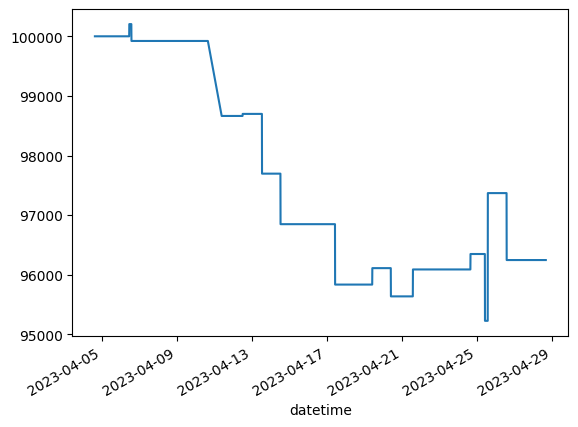

1 ('MMM', 'JPM')


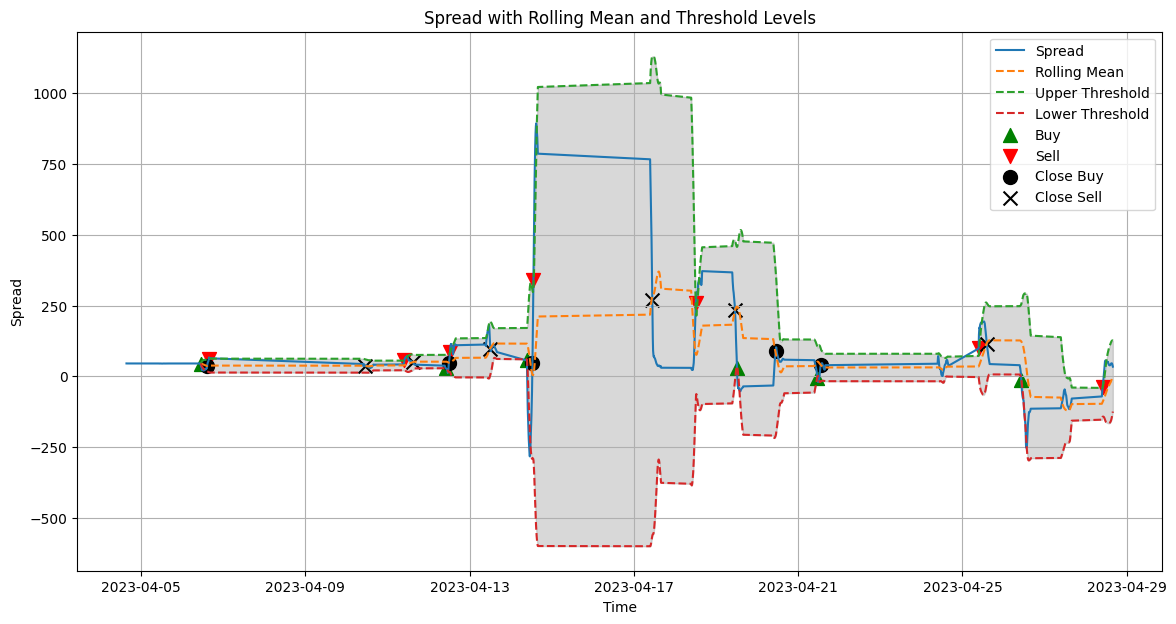

Trade Metrics:
Average Trade Return: -1.0872553901857918
Standard Deviation of Trade Returns: 5.4592251570578725
Sharpe Ratio: -3.1615556691159283
Cumulative Return: -0.02926846348285117


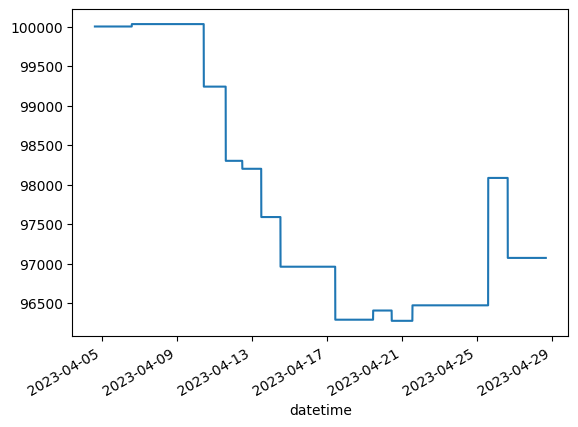

2 ('AAPL', 'DIS')


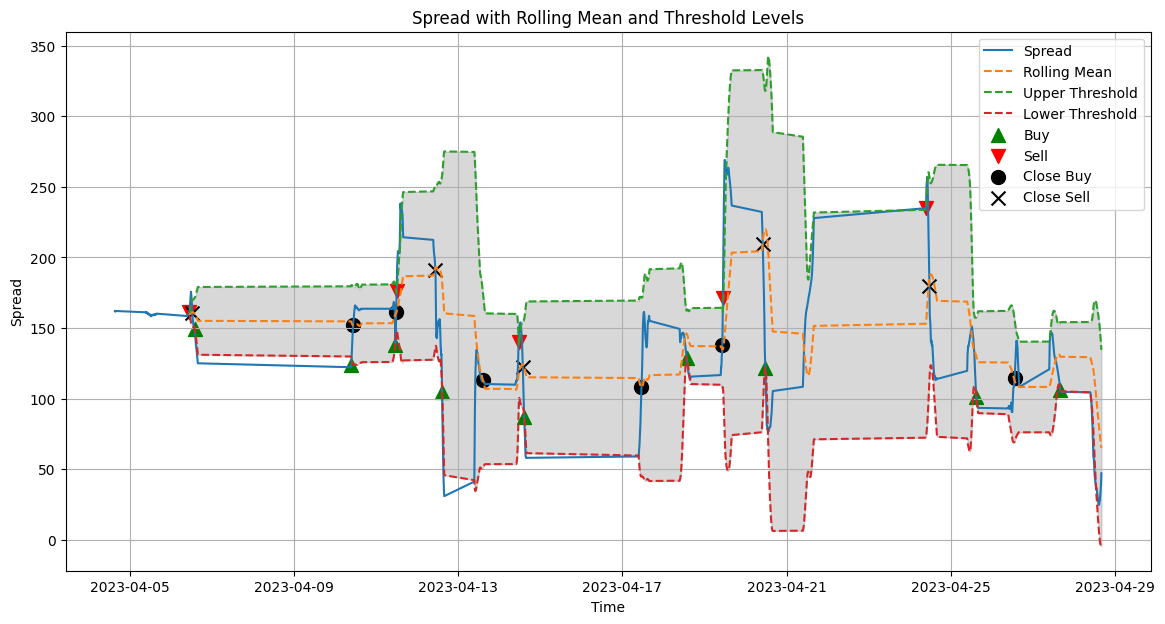

Trade Metrics:
Average Trade Return: -0.13753233556776587
Standard Deviation of Trade Returns: 4.875574993006544
Sharpe Ratio: -0.447795007970298
Cumulative Return: -0.000620109074507047


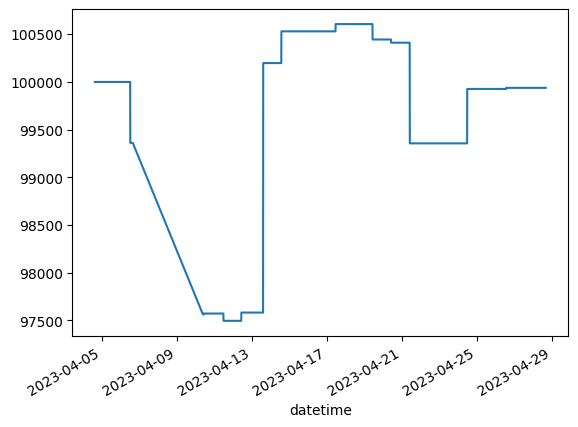

3 ('KO', 'COST')


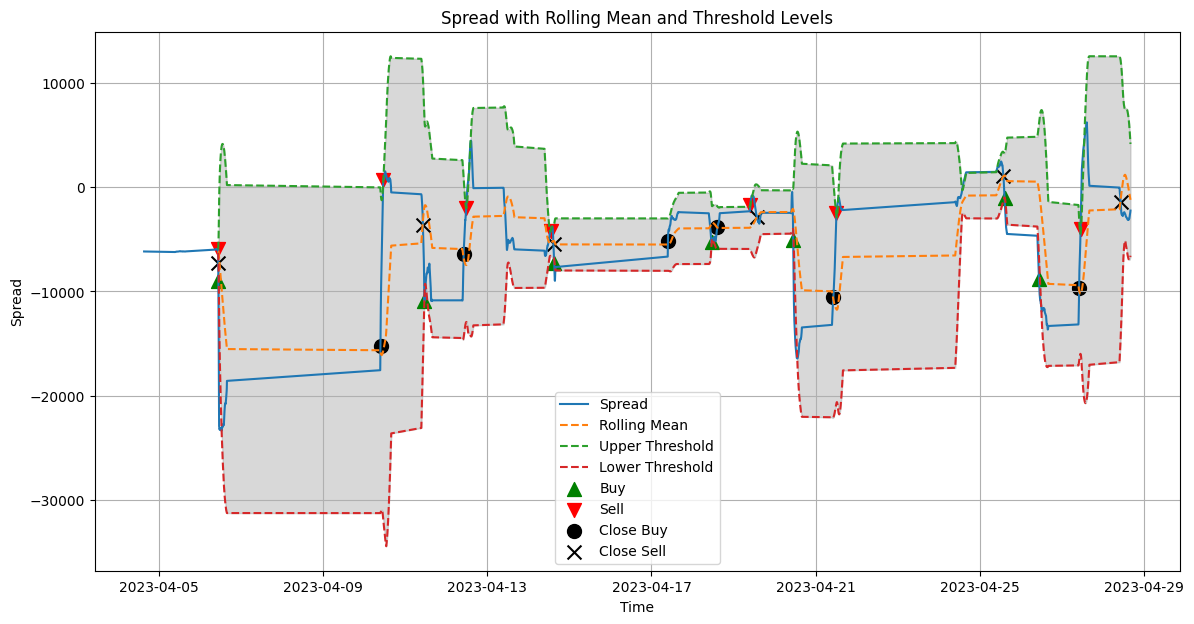

Trade Metrics:
Average Trade Return: -0.07842950334721932
Standard Deviation of Trade Returns: 0.16305745843018404
Sharpe Ratio: -7.635527867468773
Cumulative Return: -0.03795109237643235


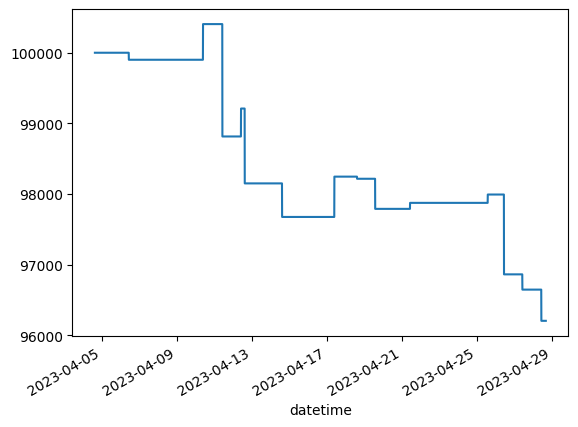

4 ('KO', 'MSFT')


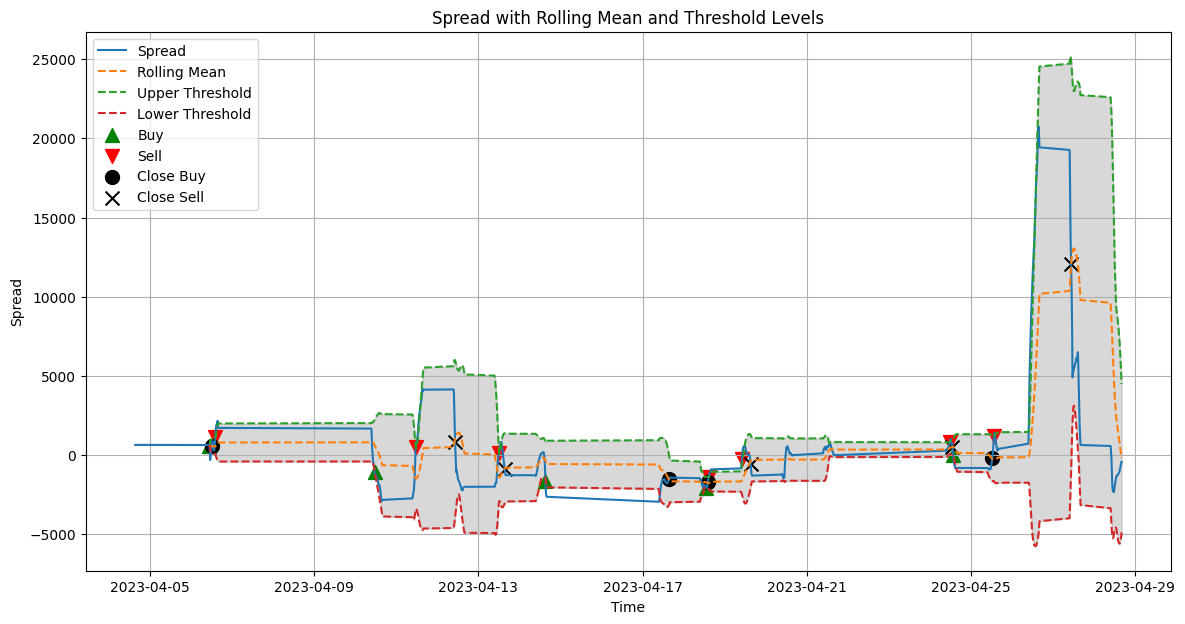

Trade Metrics:
Average Trade Return: -0.38109690387394507
Standard Deviation of Trade Returns: 1.1504569750967095
Sharpe Ratio: -5.258541544236652
Cumulative Return: -0.1195147411357026


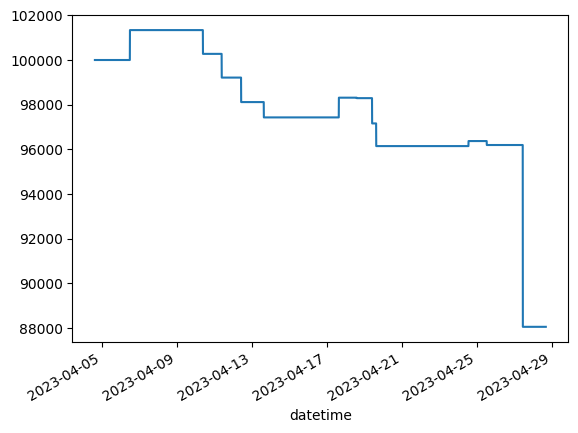

5 ('KO', 'PYPL')


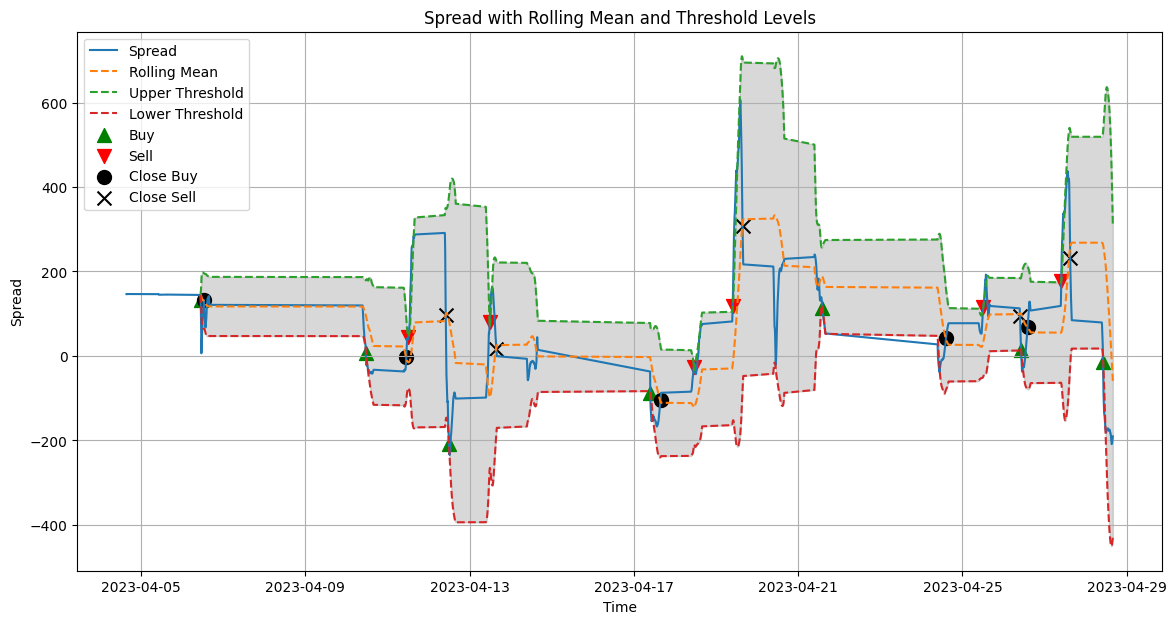

Trade Metrics:
Average Trade Return: -2.834363236805036
Standard Deviation of Trade Returns: 5.8366243949099275
Sharpe Ratio: -7.708928732522212
Cumulative Return: -0.04381471458318731


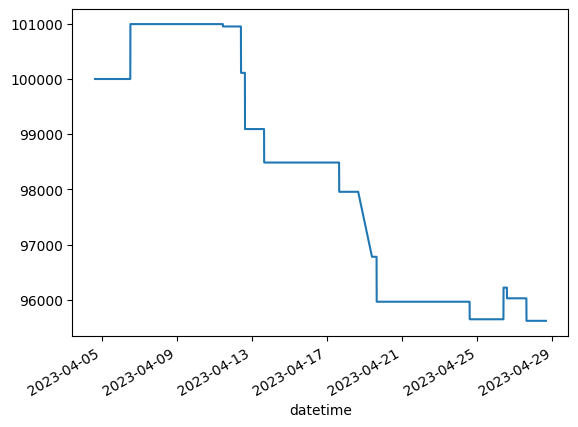

6 ('KO', 'PFE')


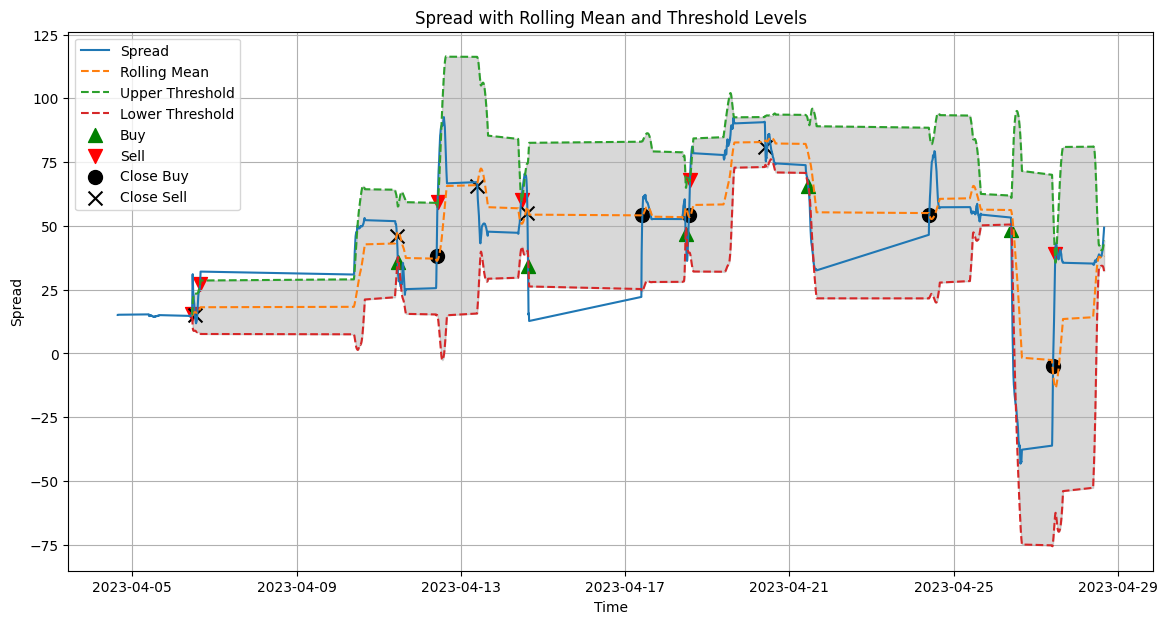

Trade Metrics:
Average Trade Return: 1.424803861219423
Standard Deviation of Trade Returns: 5.2572357690993075
Sharpe Ratio: 4.302272353073885
Cumulative Return: 0.00690047468580679


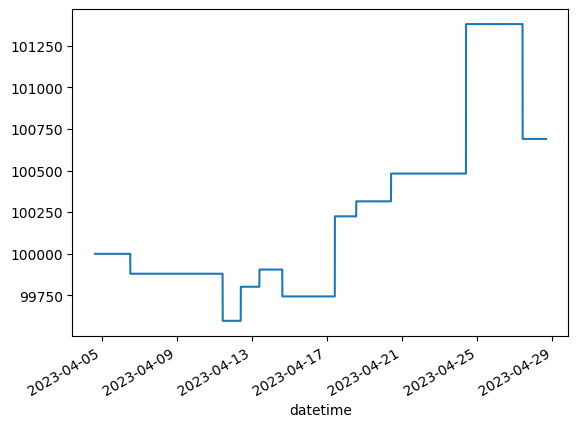

7 ('KO', 'O')


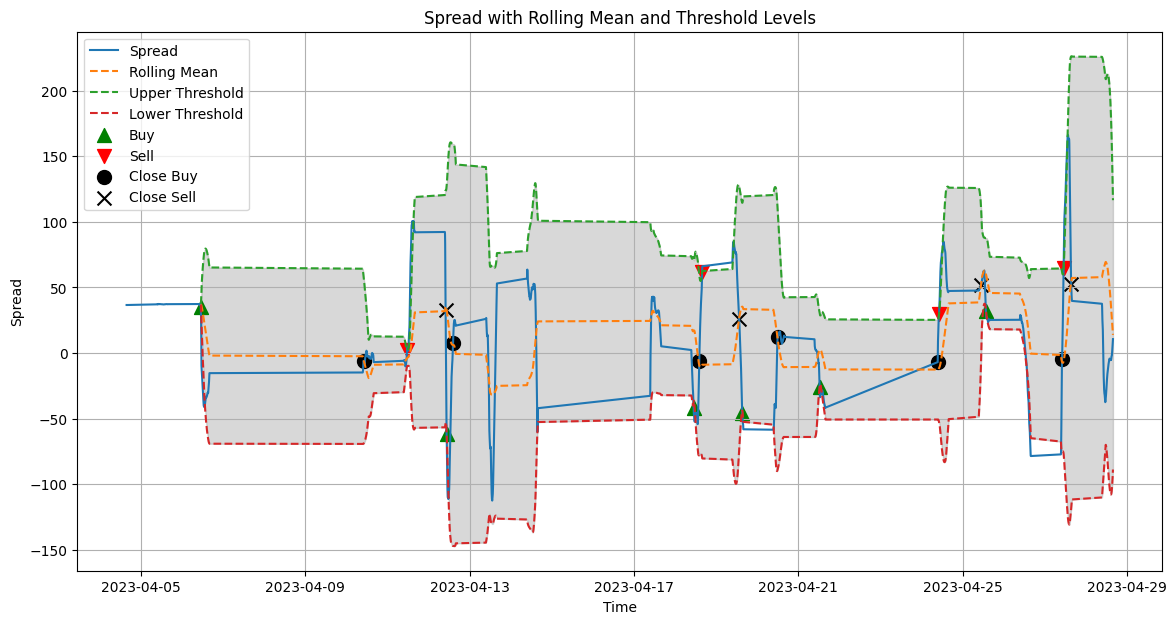

Trade Metrics:
Average Trade Return: -2.101379563977205
Standard Deviation of Trade Returns: 4.681212001992572
Sharpe Ratio: -7.126010615290032
Cumulative Return: -0.019935734777963954


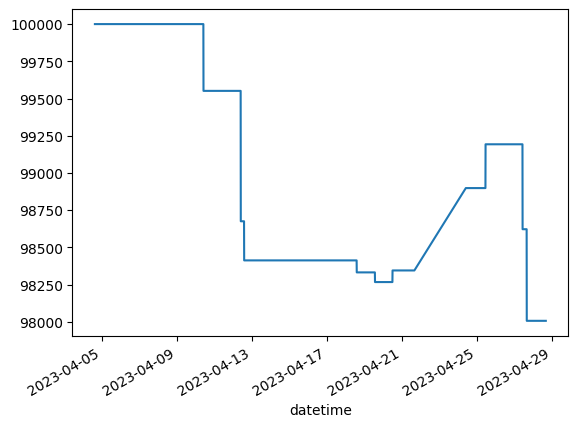

8 ('KO', 'VZ')


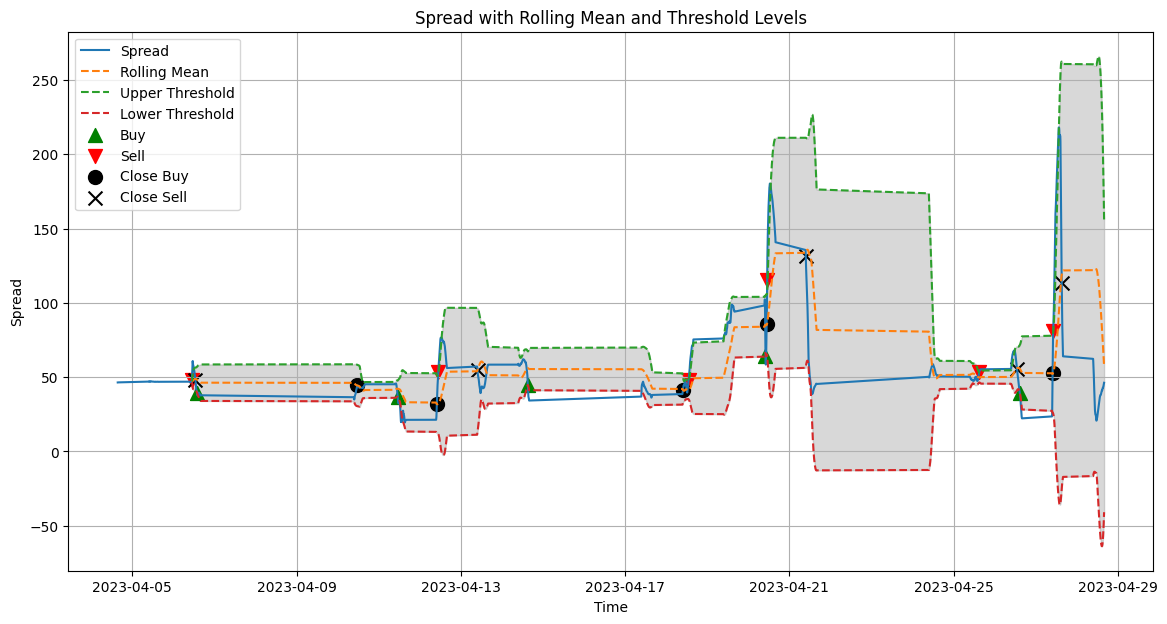

Trade Metrics:
Average Trade Return: 0.01753041911726274
Standard Deviation of Trade Returns: 6.665496915759023
Sharpe Ratio: 0.041750342051785114
Cumulative Return: -0.004552426641847962


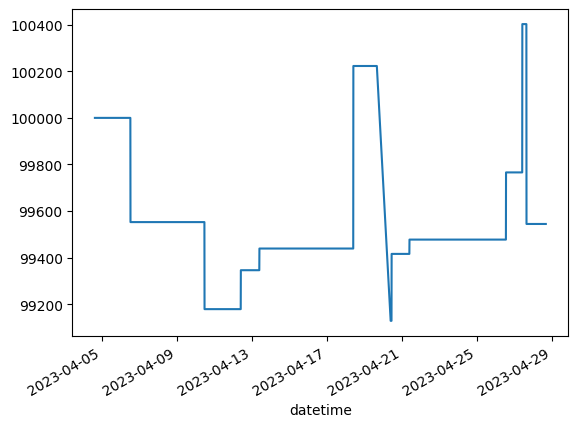

9 ('KO', 'DIS')


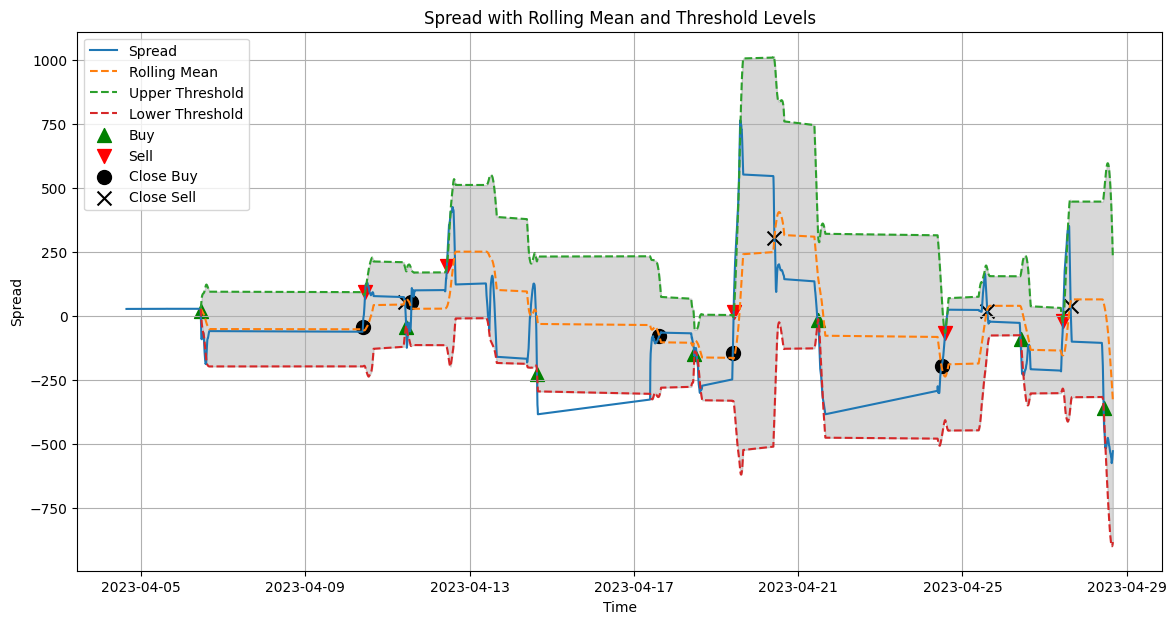

Trade Metrics:
Average Trade Return: -2.3395535596896164
Standard Deviation of Trade Returns: 6.313166355473655
Sharpe Ratio: -5.882826349875485
Cumulative Return: -0.03172029697873502


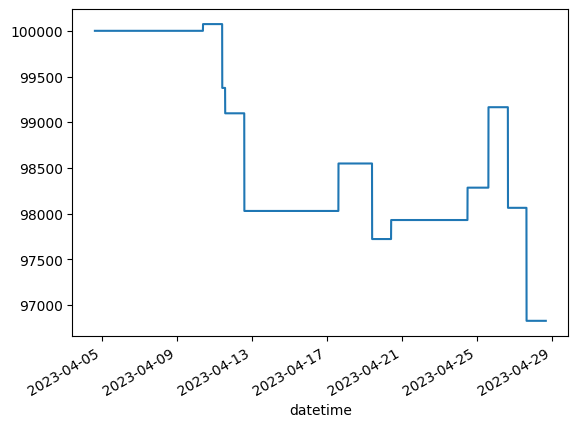

Clustering for 4 2023
DBSCAN(eps=1.5, min_samples=3)

Clusters discovered: 6
0 ('MMM', 'PFE')


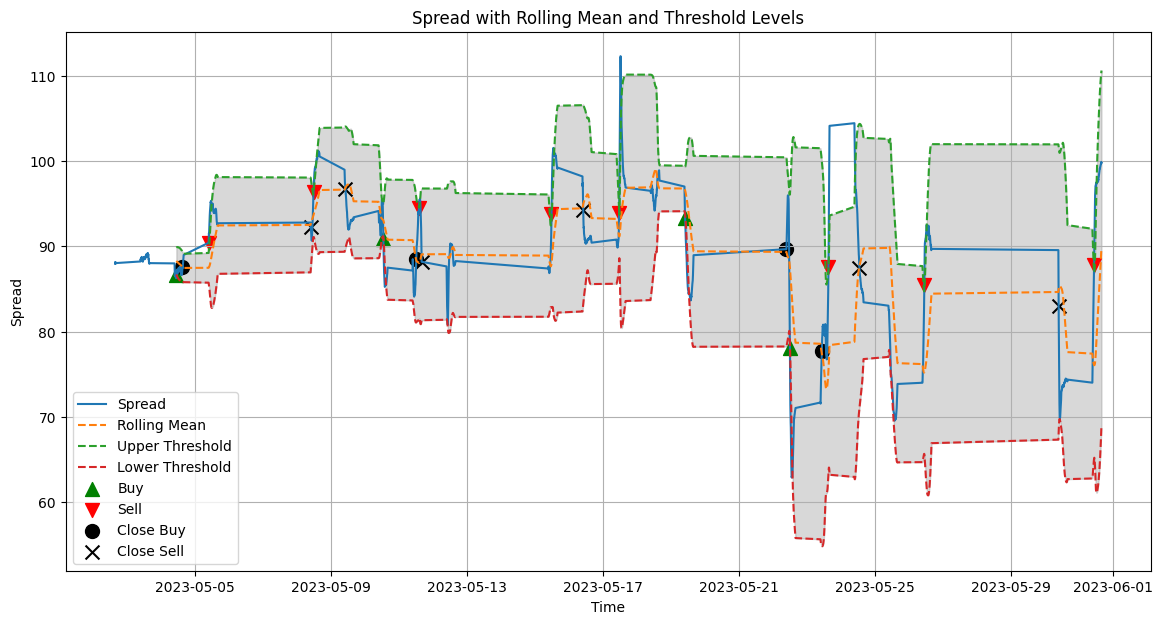

Trade Metrics:
Average Trade Return: 7.183060622550985
Standard Deviation of Trade Returns: 12.813691047043553
Sharpe Ratio: 8.898884165287667
Cumulative Return: 0.07959273083567409


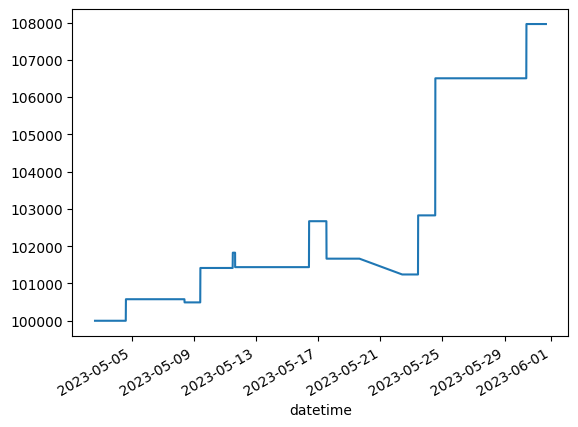

1 ('BAC', 'KO')


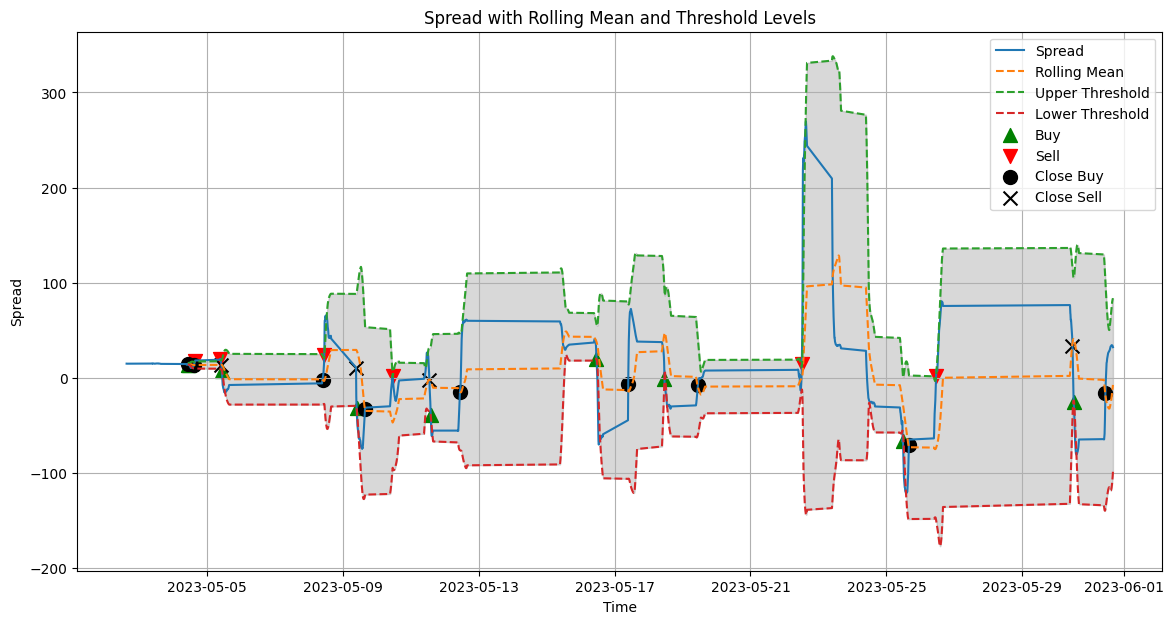

Trade Metrics:
Average Trade Return: 2.0070556341461643
Standard Deviation of Trade Returns: 19.280646206844033
Sharpe Ratio: 1.6524871682579316
Cumulative Return: 0.010554784709684073


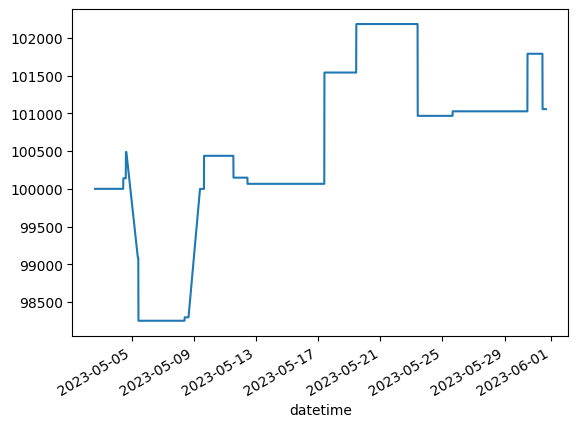

2 ('BAC', 'NKE')


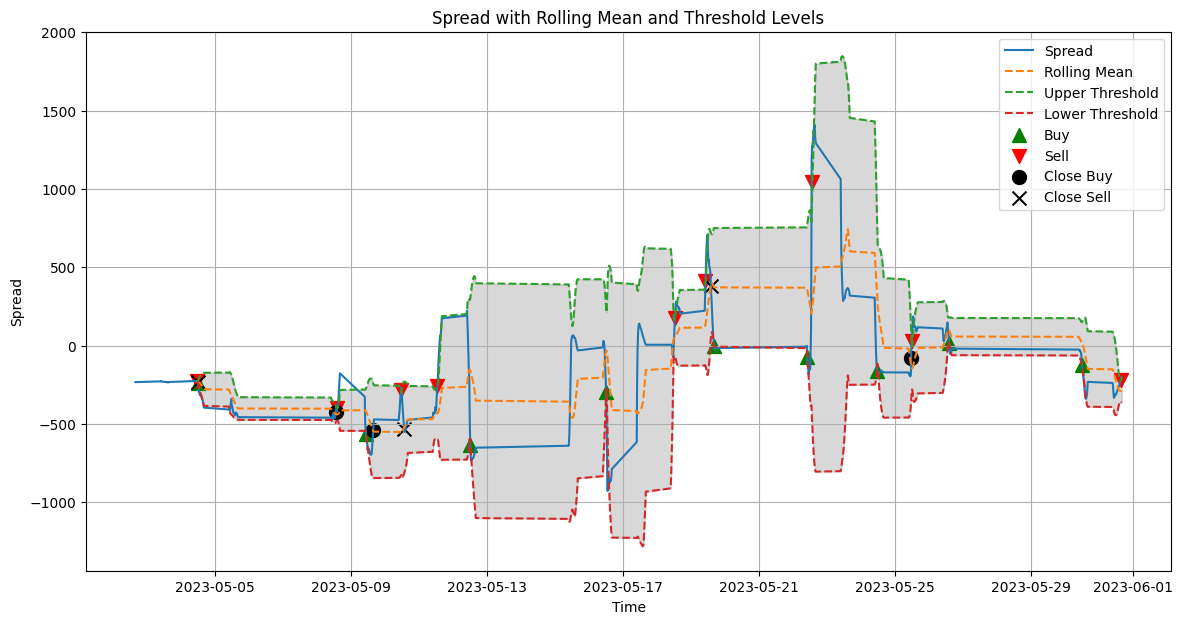

Trade Metrics:
Average Trade Return: -5.120283950341075
Standard Deviation of Trade Returns: 9.960859866322167
Sharpe Ratio: -8.160137672716694
Cumulative Return: -0.09784159744401422


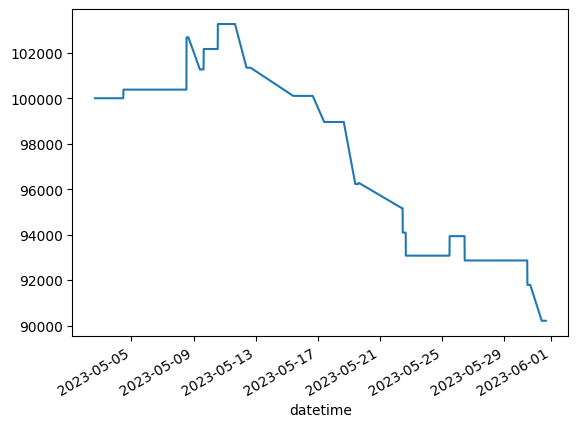

3 ('BAC', 'PFE')


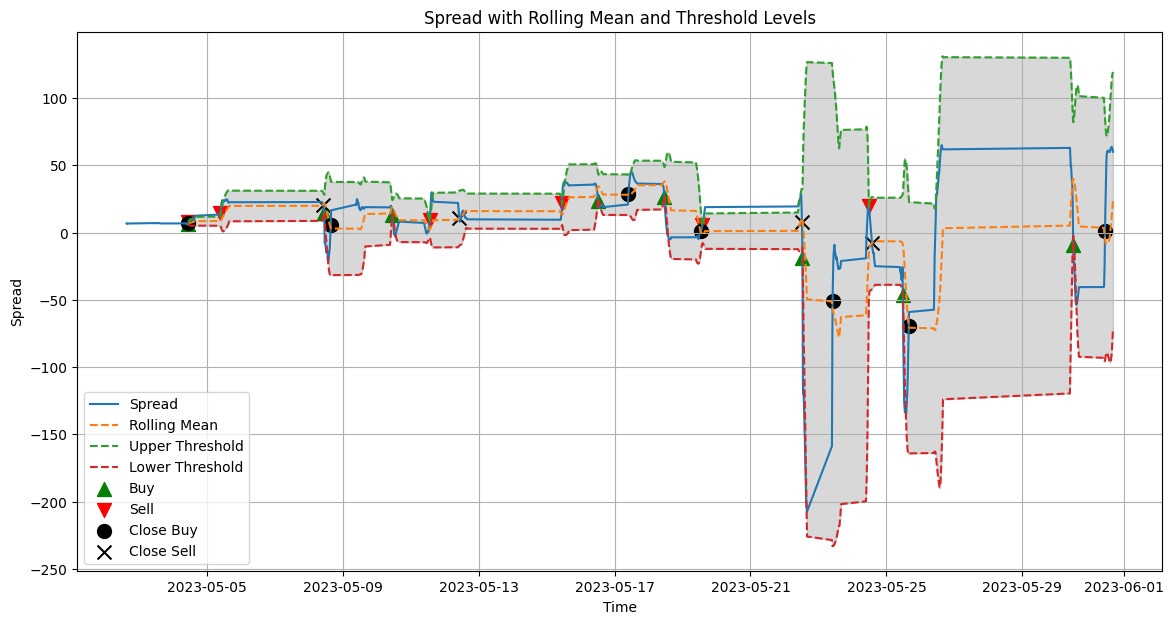

Trade Metrics:
Average Trade Return: -3.90126523460956
Standard Deviation of Trade Returns: 23.43961547596785
Sharpe Ratio: -2.64213658791331
Cumulative Return: -0.02690948983078212


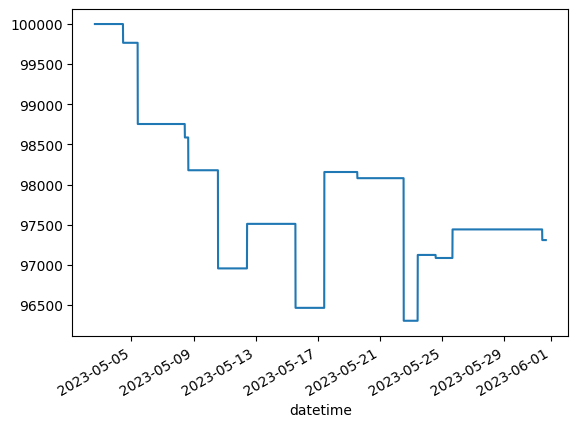

4 ('KO', 'OXY')


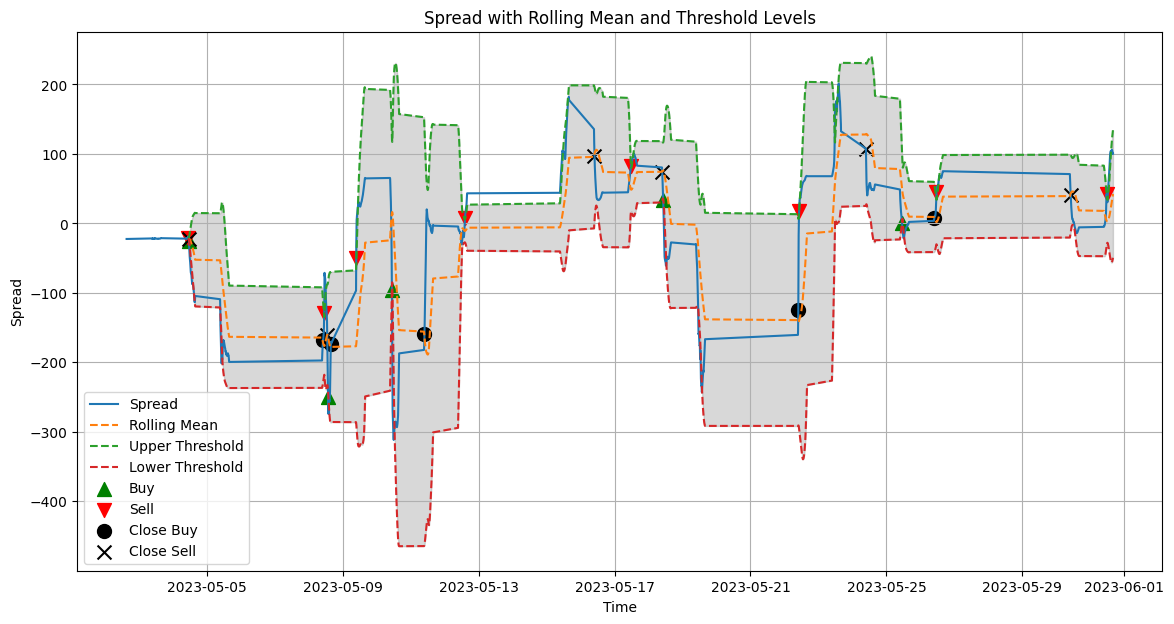

Trade Metrics:
Average Trade Return: -0.5833297966571441
Standard Deviation of Trade Returns: 7.069538917263051
Sharpe Ratio: -1.3098553603149397
Cumulative Return: 0.0020041722415546914


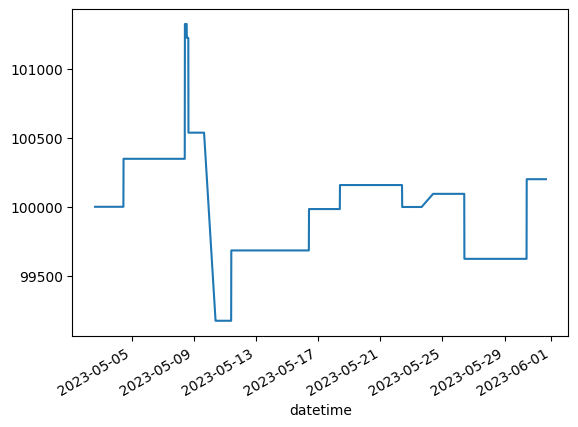

5 ('XOM', 'PFE')


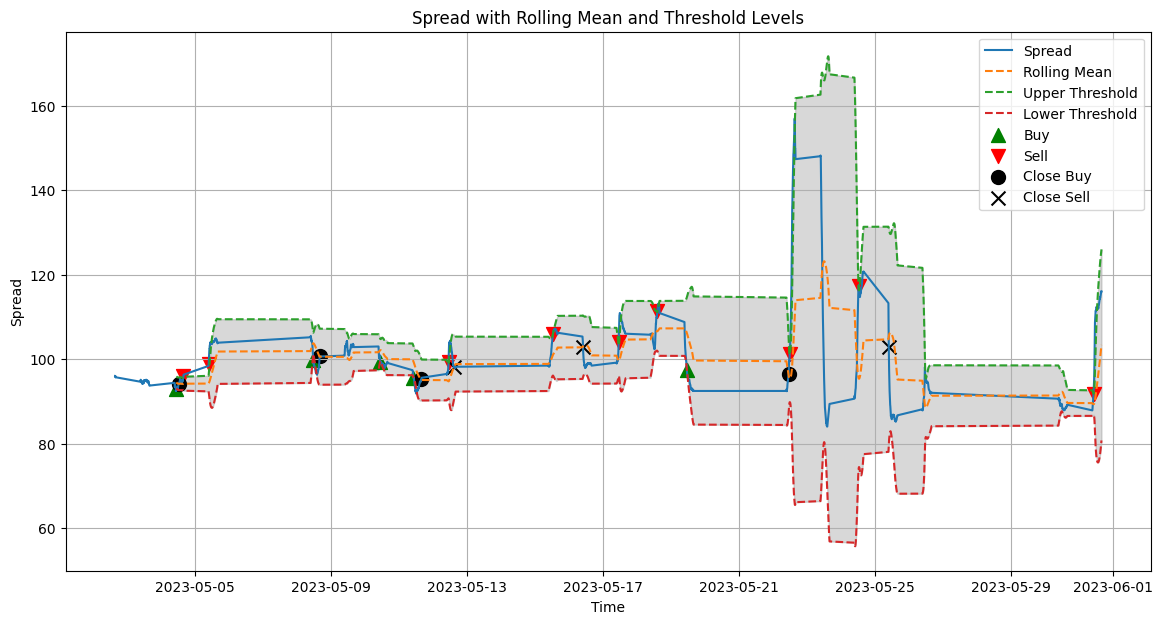

Trade Metrics:
Average Trade Return: -2.177368734483296
Standard Deviation of Trade Returns: 11.58619545072788
Sharpe Ratio: -2.9832620423652454
Cumulative Return: -0.03464945830714894


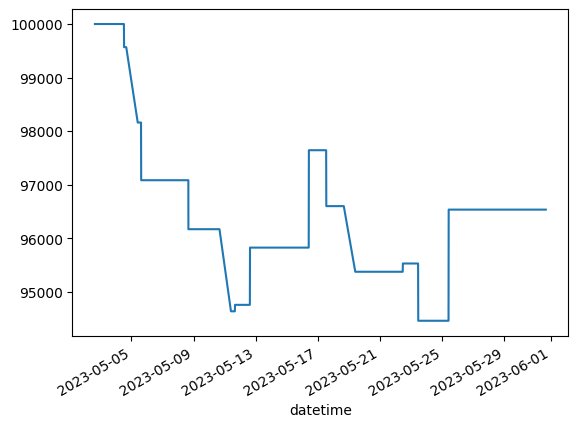

6 ('NKE', 'OXY')


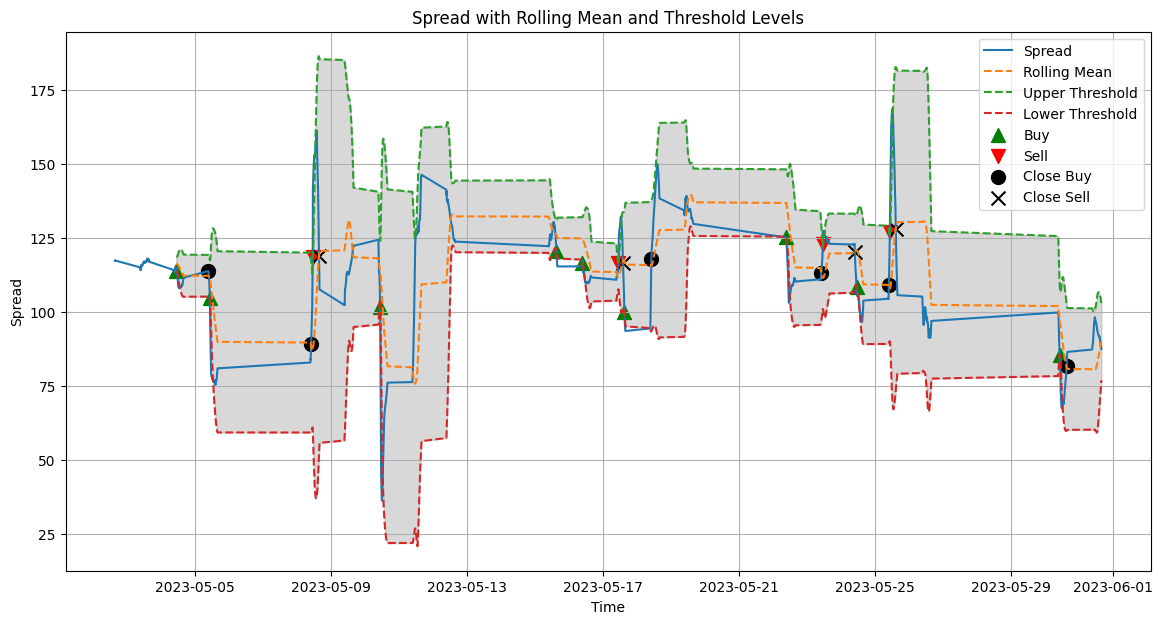

Trade Metrics:
Average Trade Return: -0.6084046771117295
Standard Deviation of Trade Returns: 9.648750565080308
Sharpe Ratio: -1.0009715524941376
Cumulative Return: -0.00932289193726743


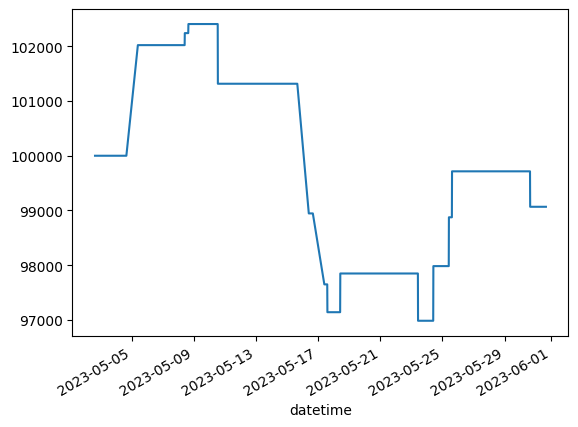

7 ('NKE', 'PFE')


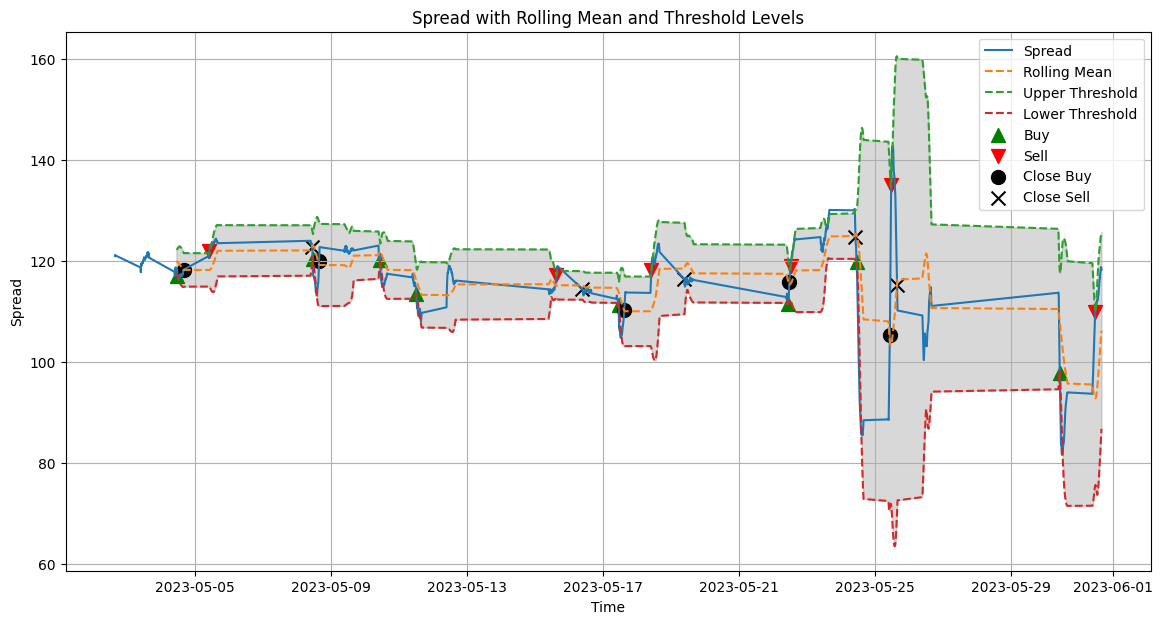

Trade Metrics:
Average Trade Return: 3.8642222476274437
Standard Deviation of Trade Returns: 13.749686286547378
Sharpe Ratio: 4.461383713710538
Cumulative Return: 0.05760878808582803


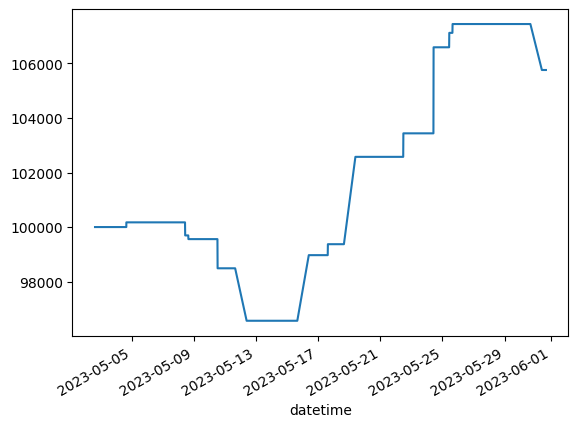

8 ('NKE', 'TGT')


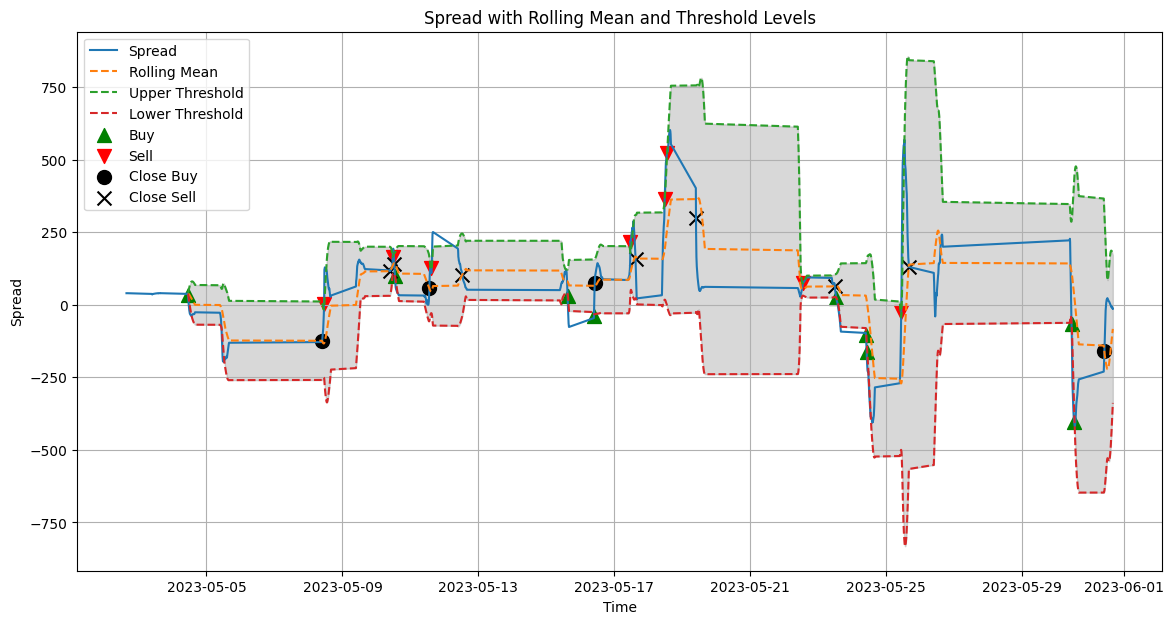

Trade Metrics:
Average Trade Return: 2.297897015406631
Standard Deviation of Trade Returns: 5.989216439726705
Sharpe Ratio: 6.090610452021927
Cumulative Return: 0.024252892793707126


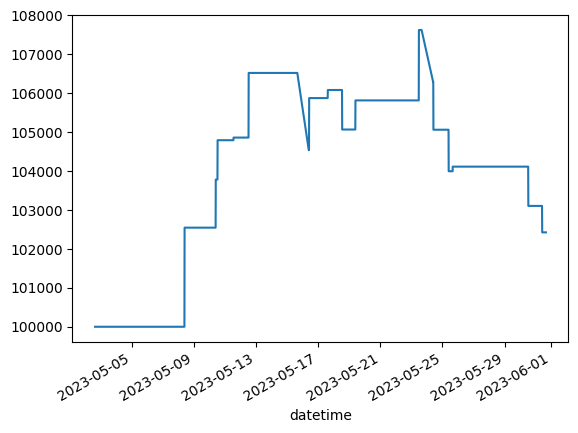

9 ('NKE', 'VZ')


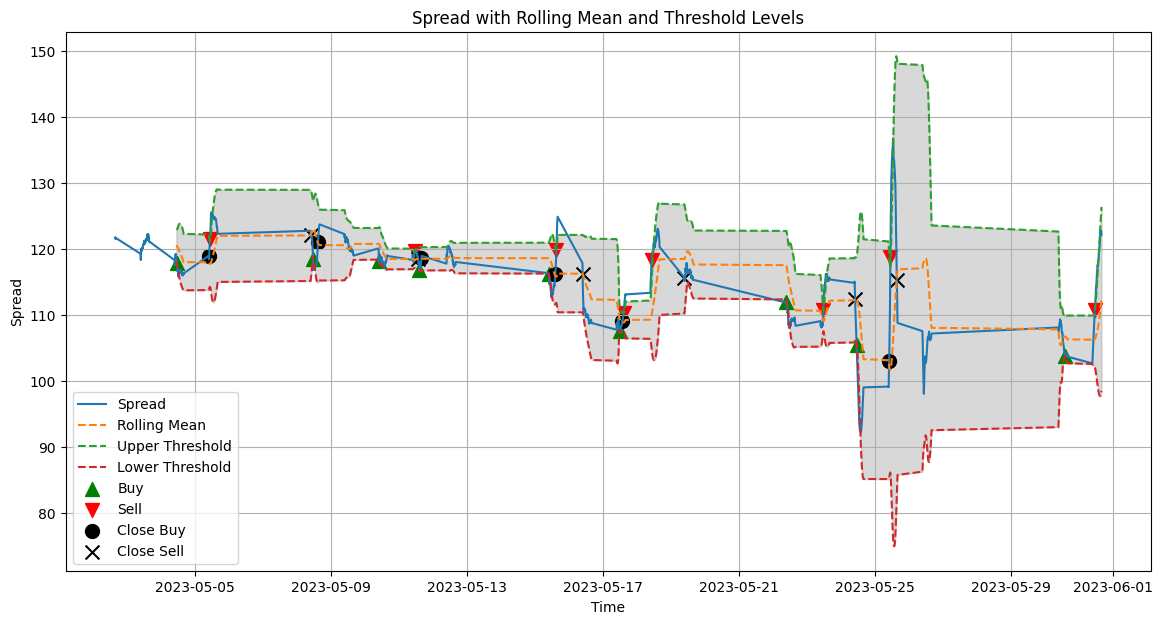

Trade Metrics:
Average Trade Return: 4.320769159846243
Standard Deviation of Trade Returns: 11.222591065243387
Sharpe Ratio: 6.111786807348697
Cumulative Return: 0.08274554256242683


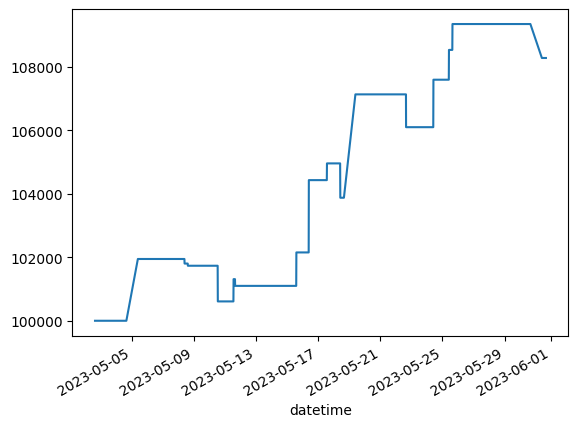

Clustering for 5 2023
DBSCAN(eps=1.5, min_samples=3)

Clusters discovered: 3
0 ('AAL', 'DAL')


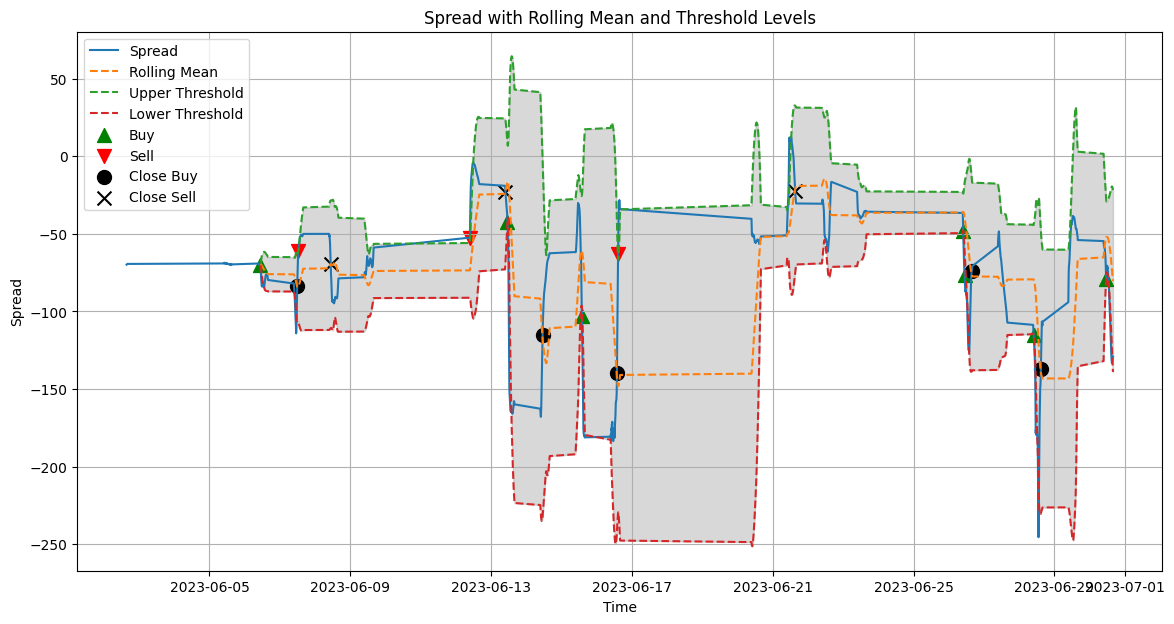

Trade Metrics:
Average Trade Return: -3.029324072024725
Standard Deviation of Trade Returns: 17.514979921603935
Sharpe Ratio: -2.7455942870866785
Cumulative Return: -0.0016429292660989914


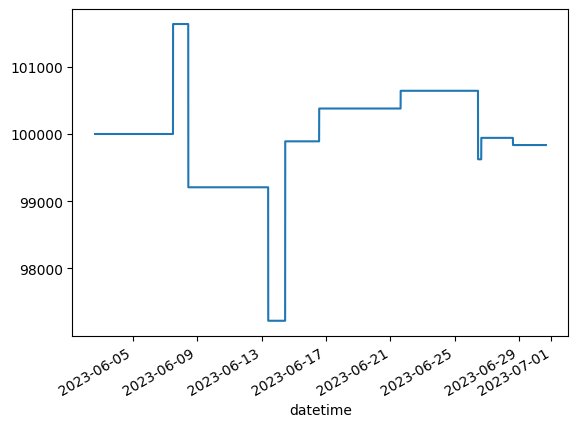

1 ('AAL', 'META')


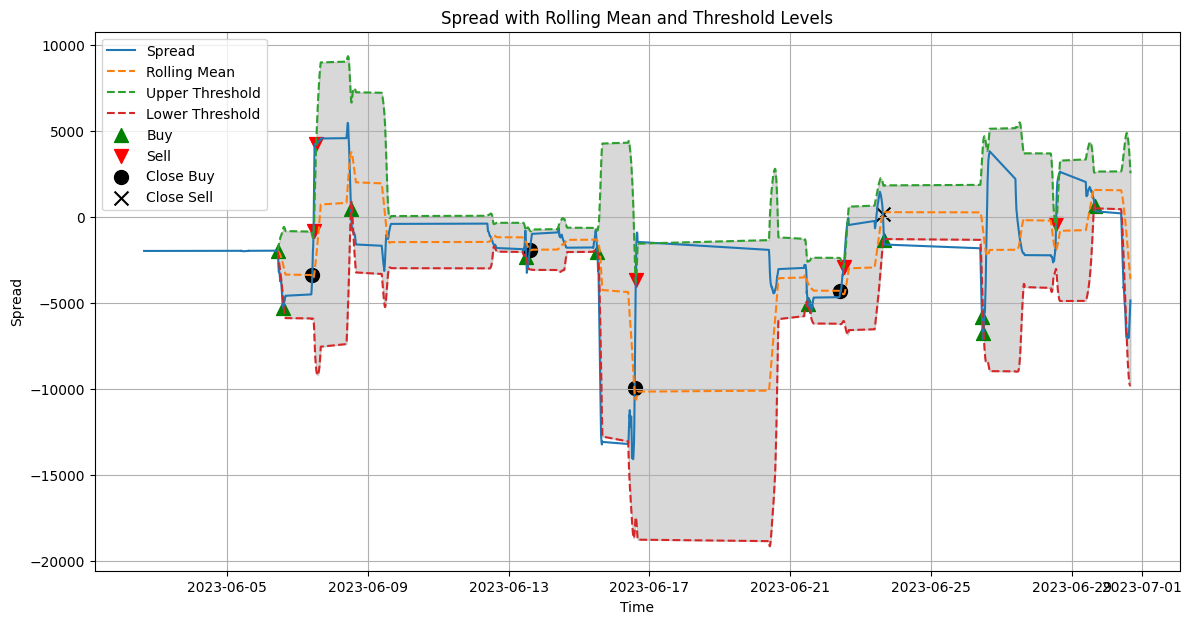

Trade Metrics:
Average Trade Return: -1.0883601295350651
Standard Deviation of Trade Returns: 3.078107212564392
Sharpe Ratio: -5.6129238667334205
Cumulative Return: -0.10148013970888703


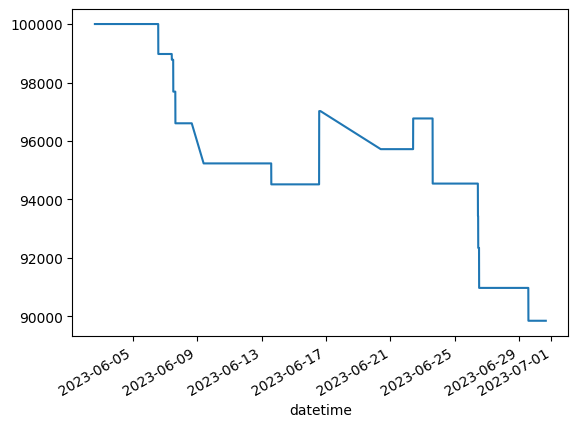

2 ('COST', 'META')


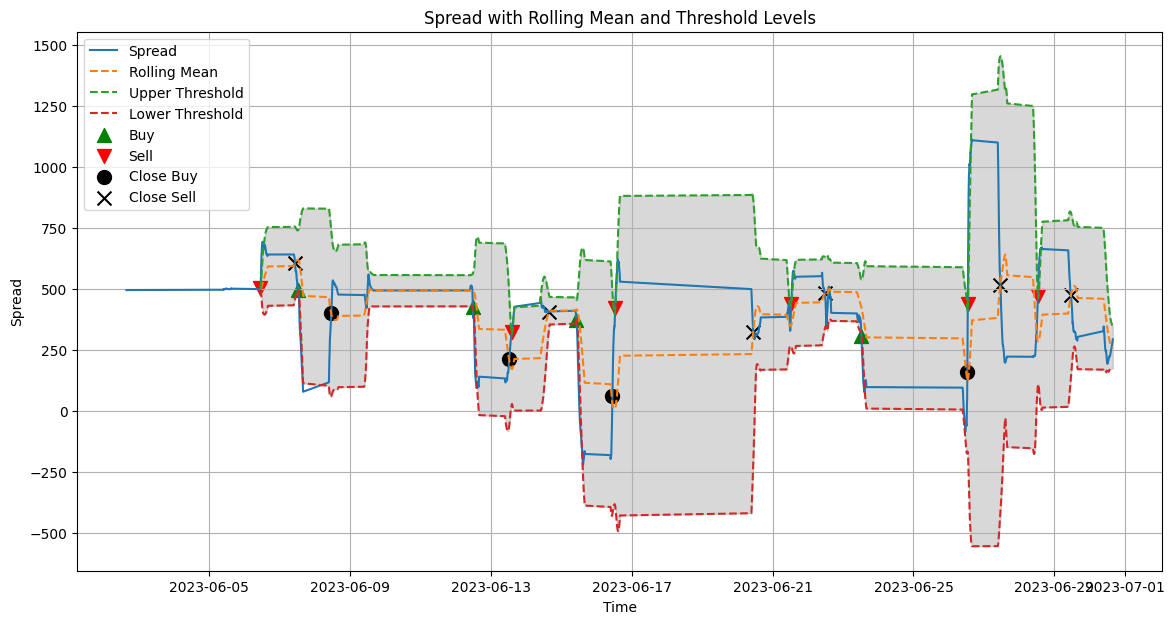

Trade Metrics:
Average Trade Return: 0.15365747358226356
Standard Deviation of Trade Returns: 1.2871844289005723
Sharpe Ratio: 1.8950173093643727
Cumulative Return: 0.013558664394897946


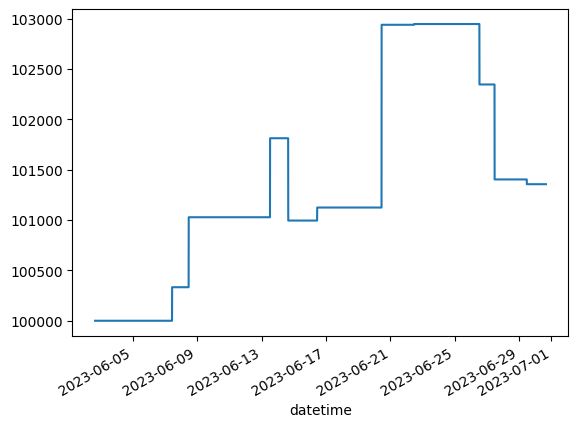

3 ('COST', 'MSFT')


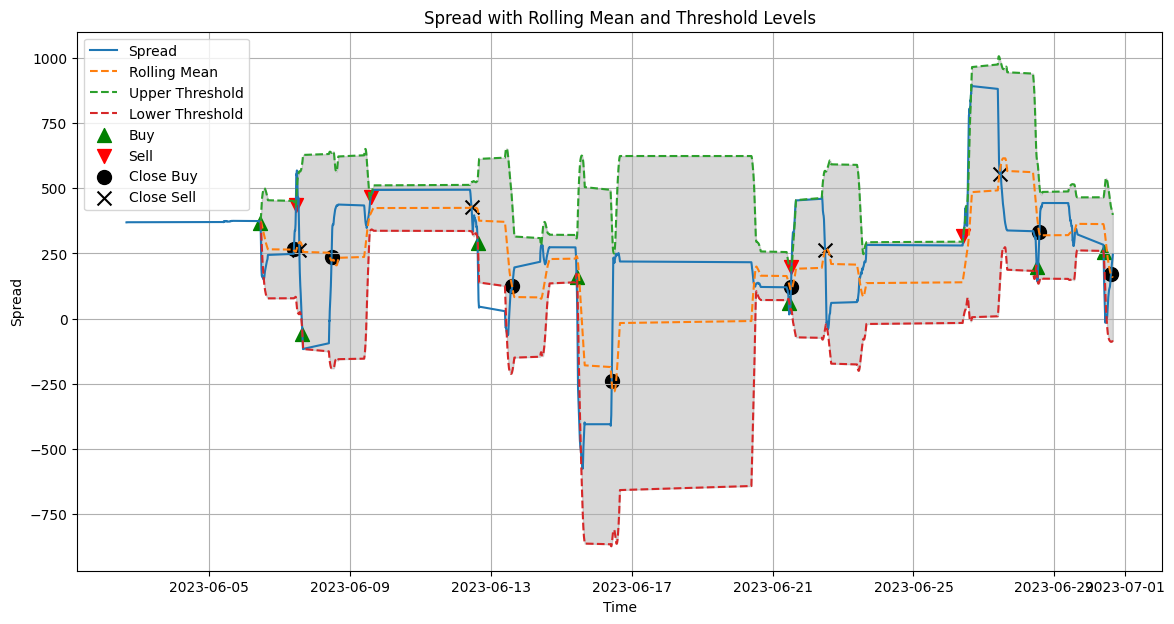

Trade Metrics:
Average Trade Return: 0.1829597403918225
Standard Deviation of Trade Returns: 0.6137252348581075
Sharpe Ratio: 4.73240413318462
Cumulative Return: 0.019005784740498965


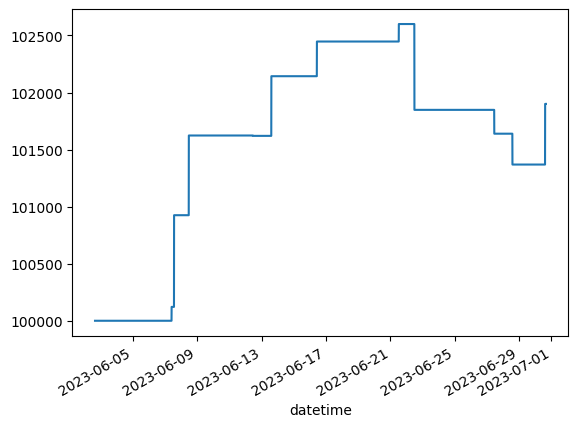

4 ('XOM', 'META')


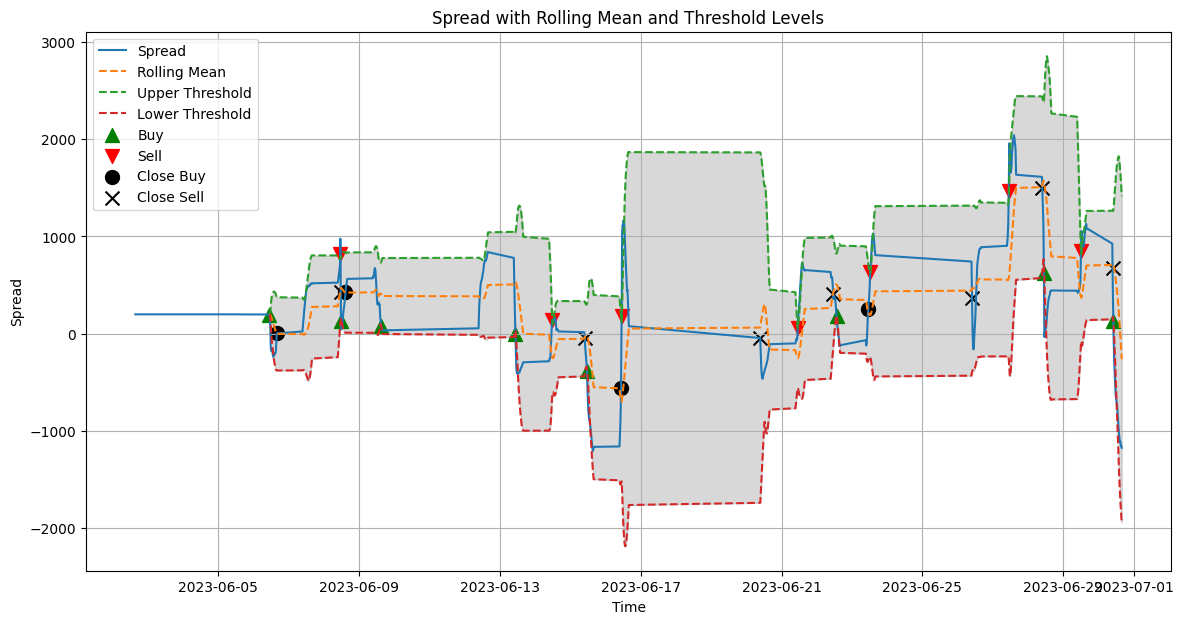

Trade Metrics:
Average Trade Return: -1.7347749963645787
Standard Deviation of Trade Returns: 4.097921048485244
Sharpe Ratio: -6.720163468347282
Cumulative Return: -0.04500533547574359


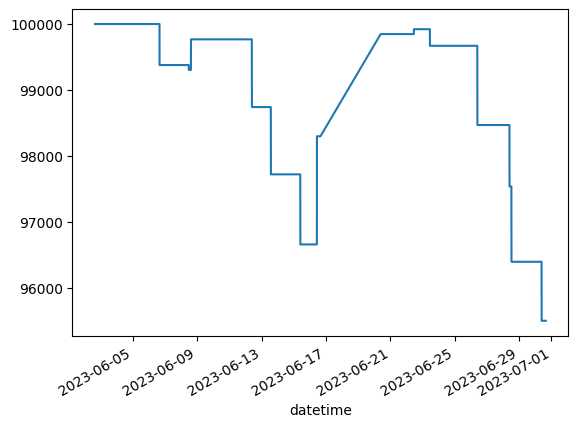

5 ('XOM', 'MSFT')


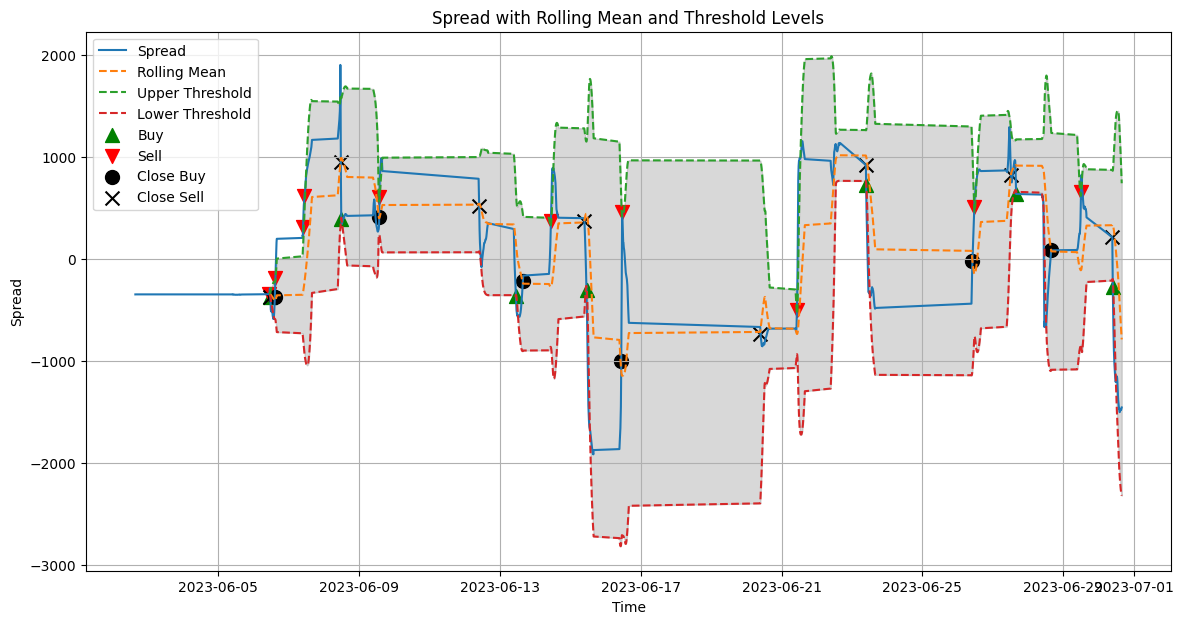

Trade Metrics:
Average Trade Return: -0.19444946451114414
Standard Deviation of Trade Returns: 2.4424116807249403
Sharpe Ratio: -1.2638285258612927
Cumulative Return: 0.0006638922996444752


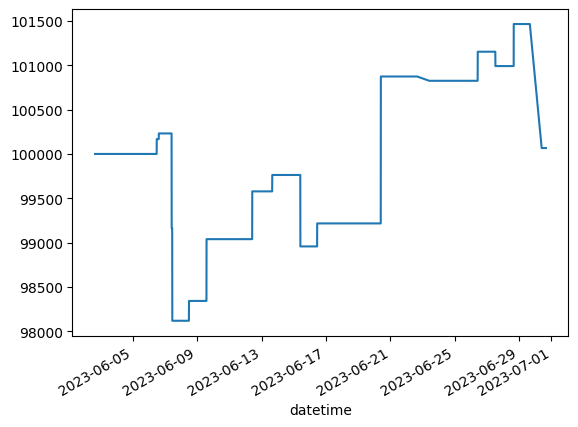

6 ('XOM', 'PFE')


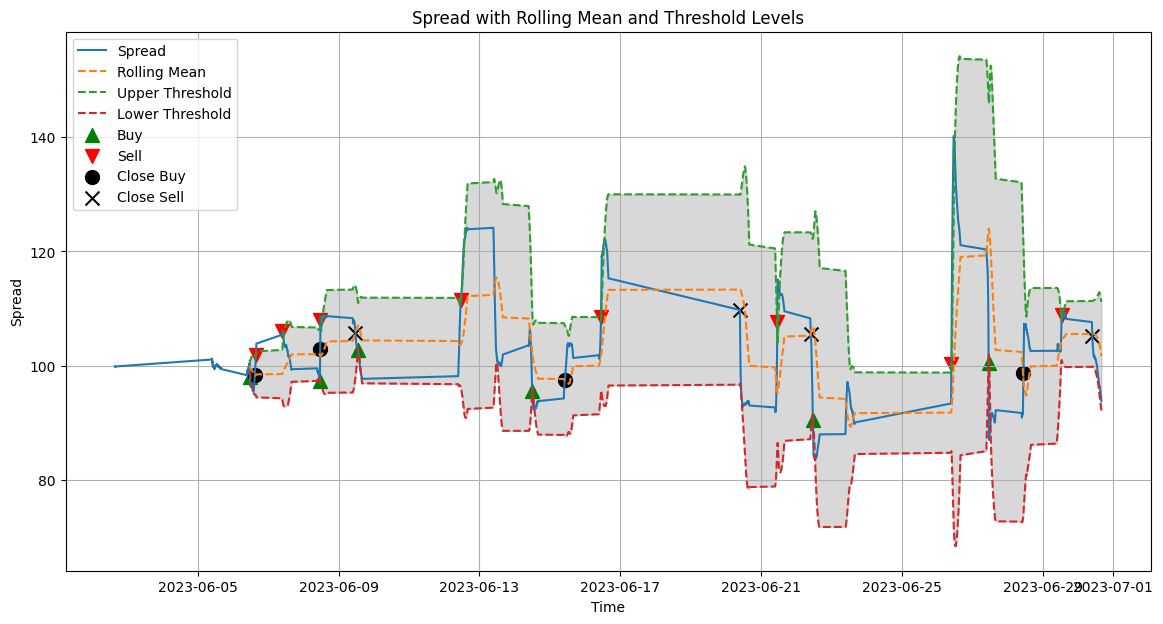

Trade Metrics:
Average Trade Return: -1.8569577302185678
Standard Deviation of Trade Returns: 9.651439142662186
Sharpe Ratio: -3.0542895893733757
Cumulative Return: -0.030781878789710726


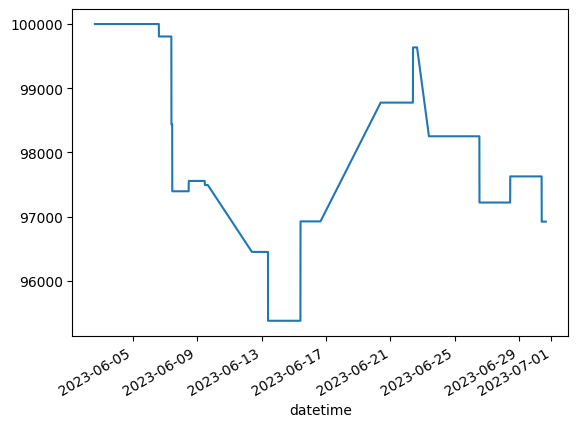

7 ('XOM', 'O')


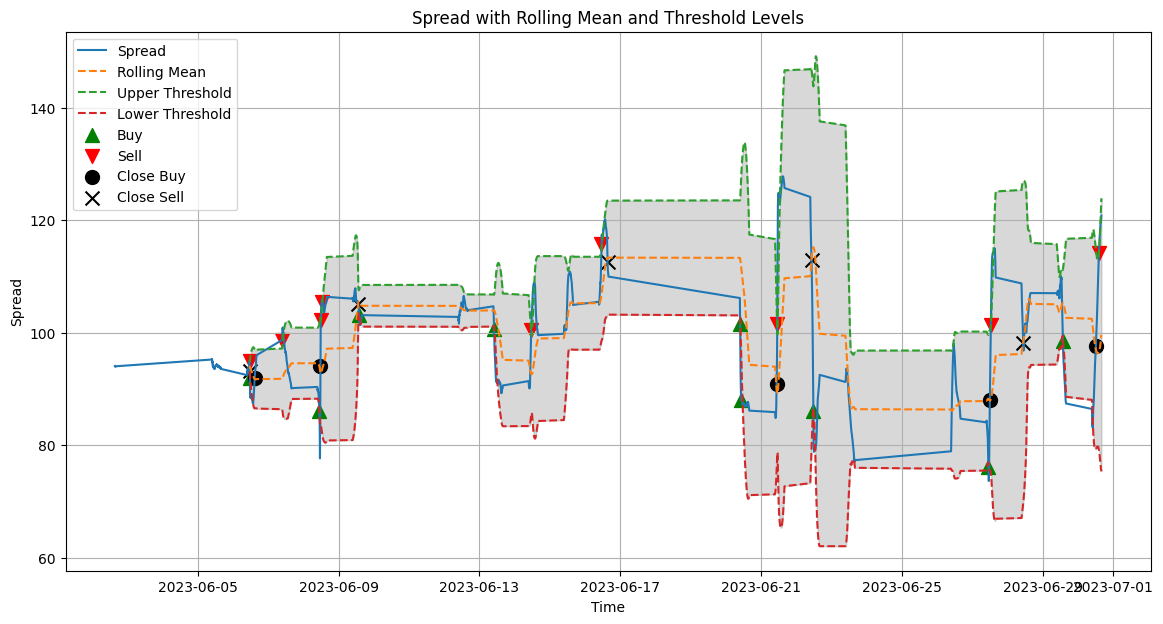

Trade Metrics:
Average Trade Return: -3.349678394958743
Standard Deviation of Trade Returns: 7.38141539527185
Sharpe Ratio: -7.203834655437733
Cumulative Return: -0.061405095268277976


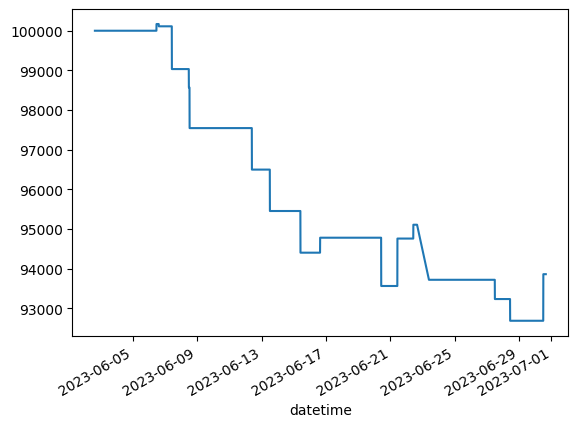

8 ('XOM', 'WBA')


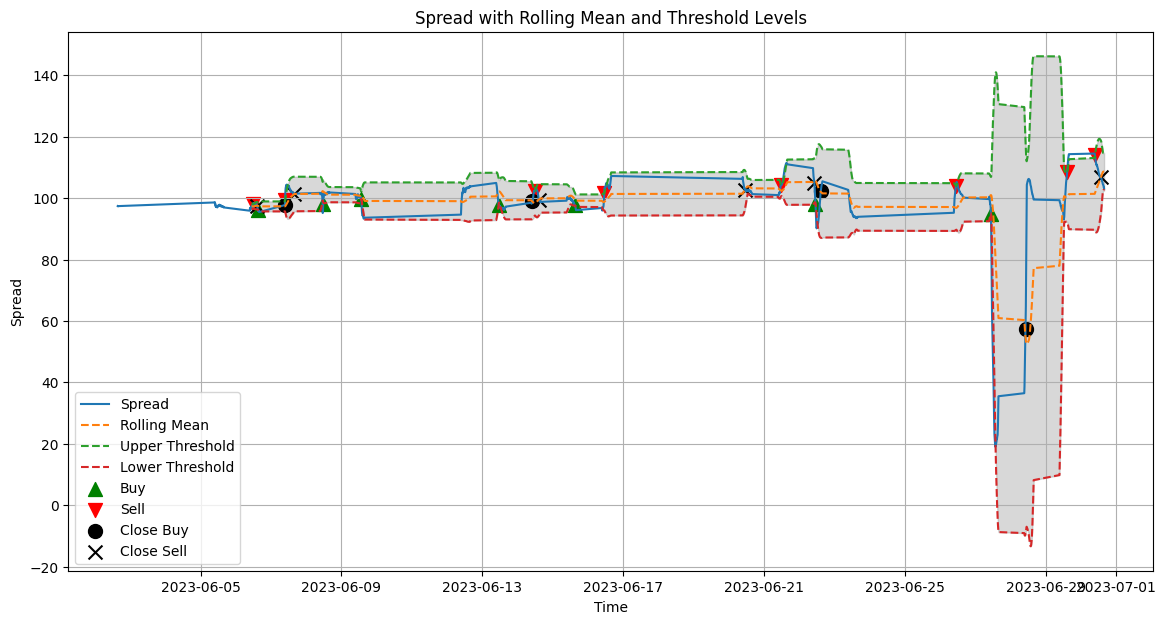

Trade Metrics:
Average Trade Return: -1.0278813587276354
Standard Deviation of Trade Returns: 10.65867192861057
Sharpe Ratio: -1.5308765317220914
Cumulative Return: -0.019908791055727515


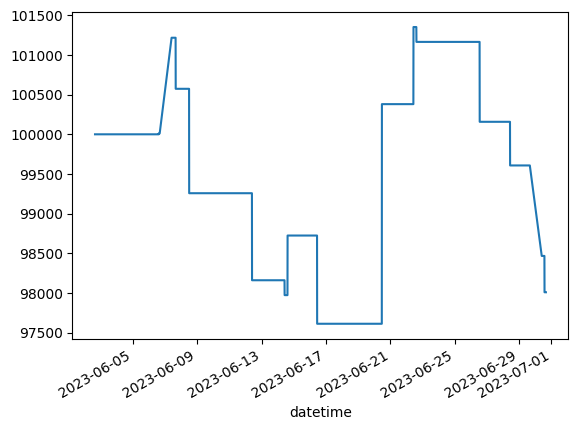

9 ('OXY', 'O')


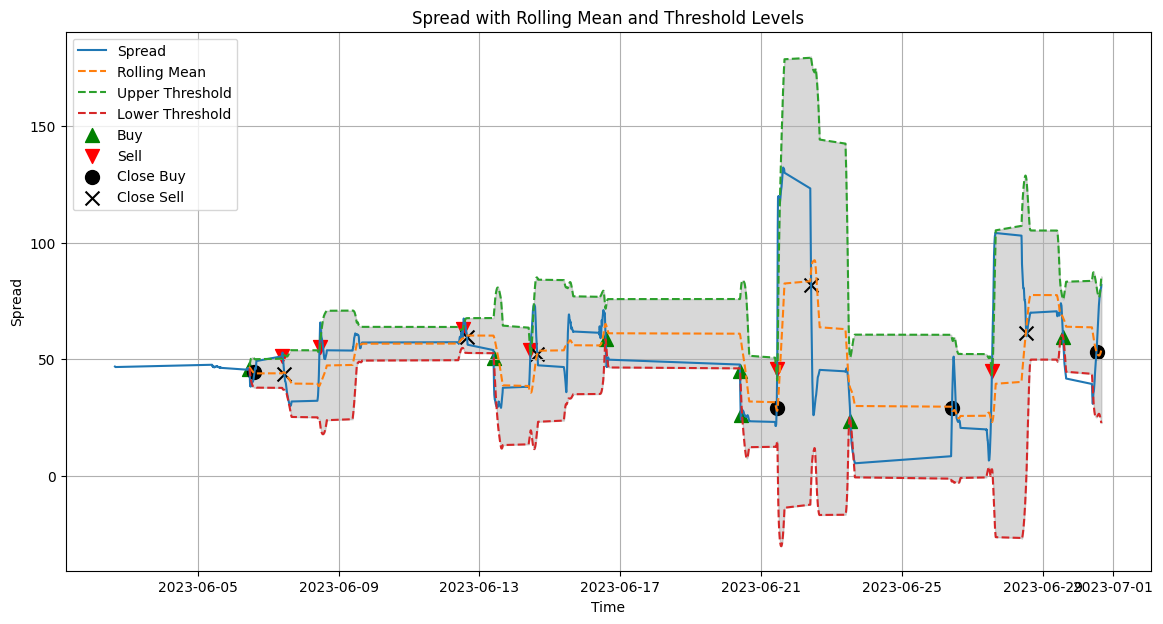

Trade Metrics:
Average Trade Return: -2.2802397153355796
Standard Deviation of Trade Returns: 13.468103703626142
Sharpe Ratio: -2.6876599775956667
Cumulative Return: -0.021262012260494956


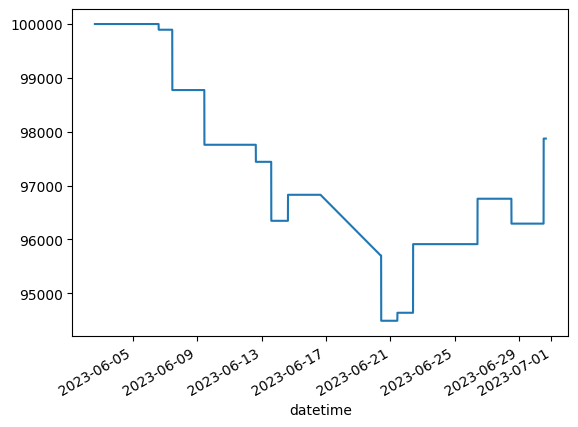

Clustering for 6 2023
DBSCAN(eps=1.5, min_samples=3)

Clusters discovered: 6
Clustering for 7 2023
DBSCAN(eps=1.5, min_samples=3)

Clusters discovered: 4
0 ('BAC', 'JPM')


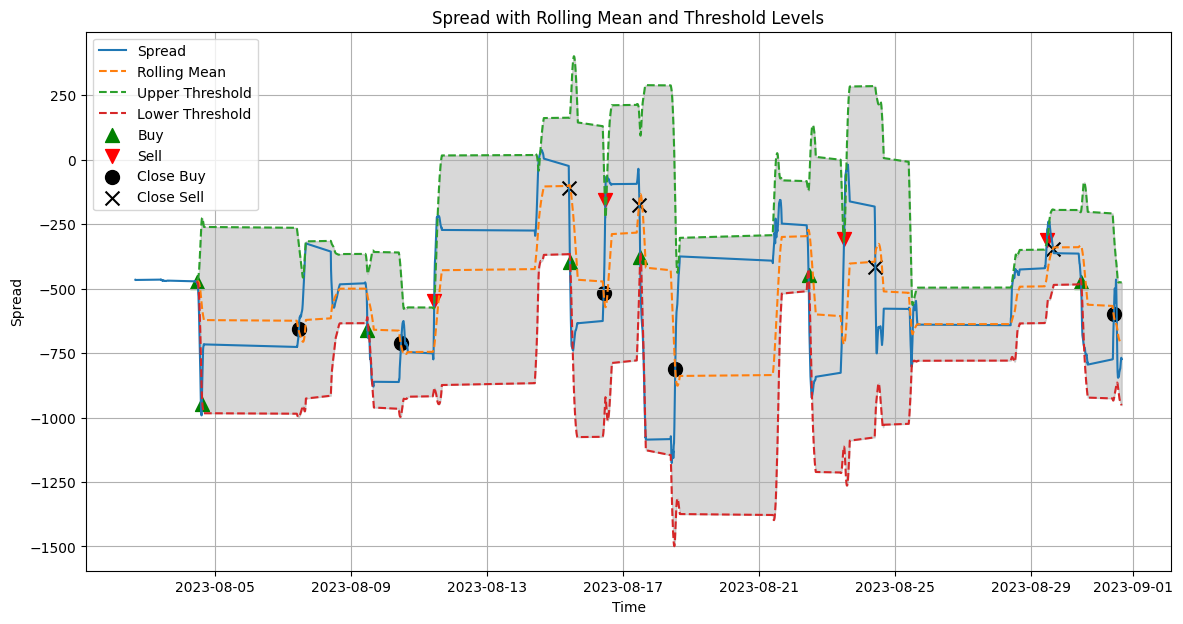

Trade Metrics:
Average Trade Return: 0.39088320194482473
Standard Deviation of Trade Returns: 3.003549700796532
Sharpe Ratio: 2.065915027963847
Cumulative Return: -0.02068816039803789


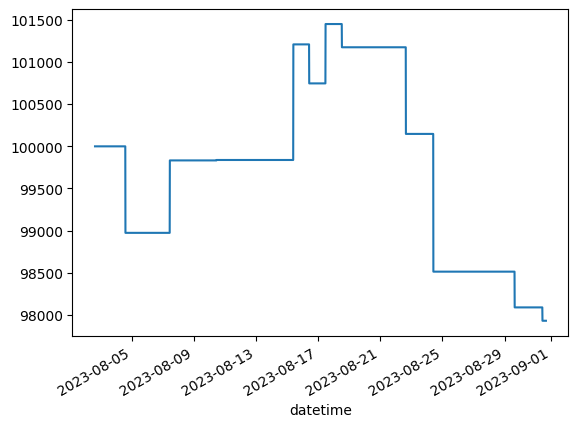

1 ('COST', 'XOM')


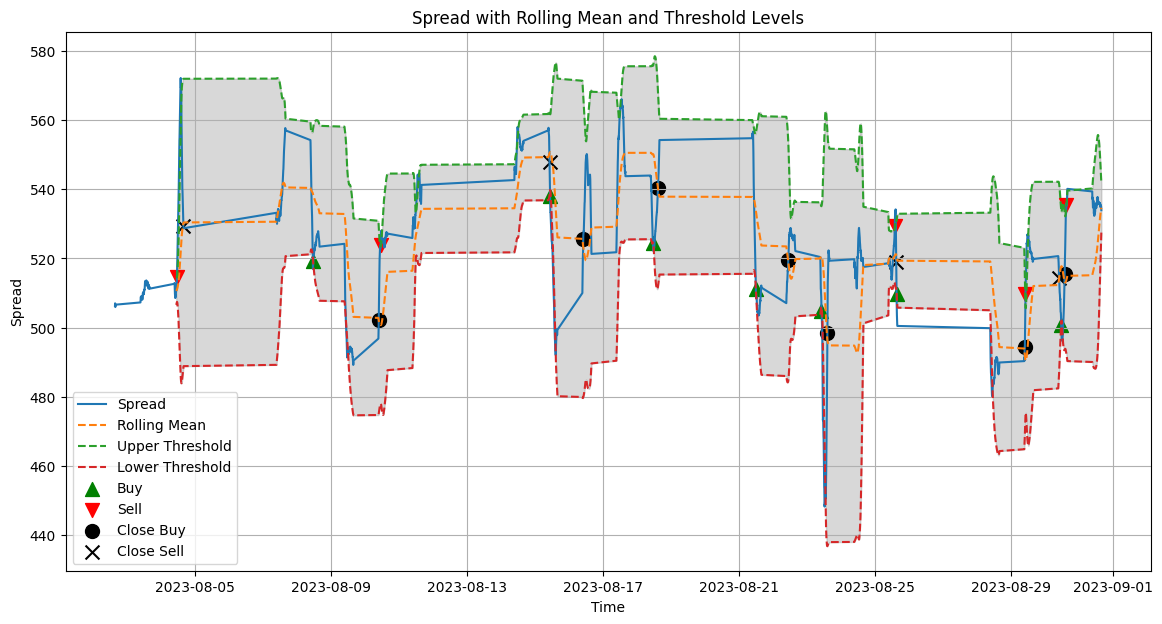

Trade Metrics:
Average Trade Return: 0.4343729651651569
Standard Deviation of Trade Returns: 1.529141395816314
Sharpe Ratio: 4.50936523680945
Cumulative Return: 0.031145806135689513


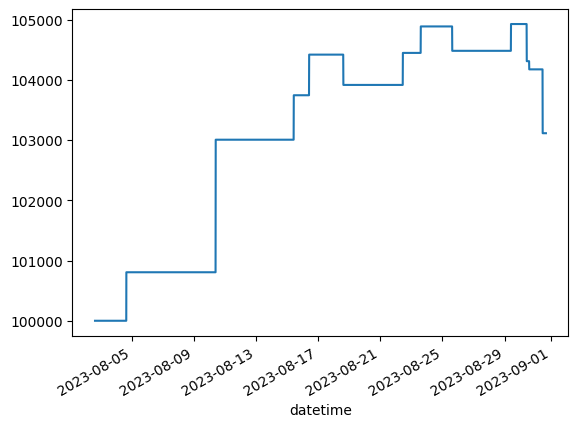

2 ('PFE', 'WBA')


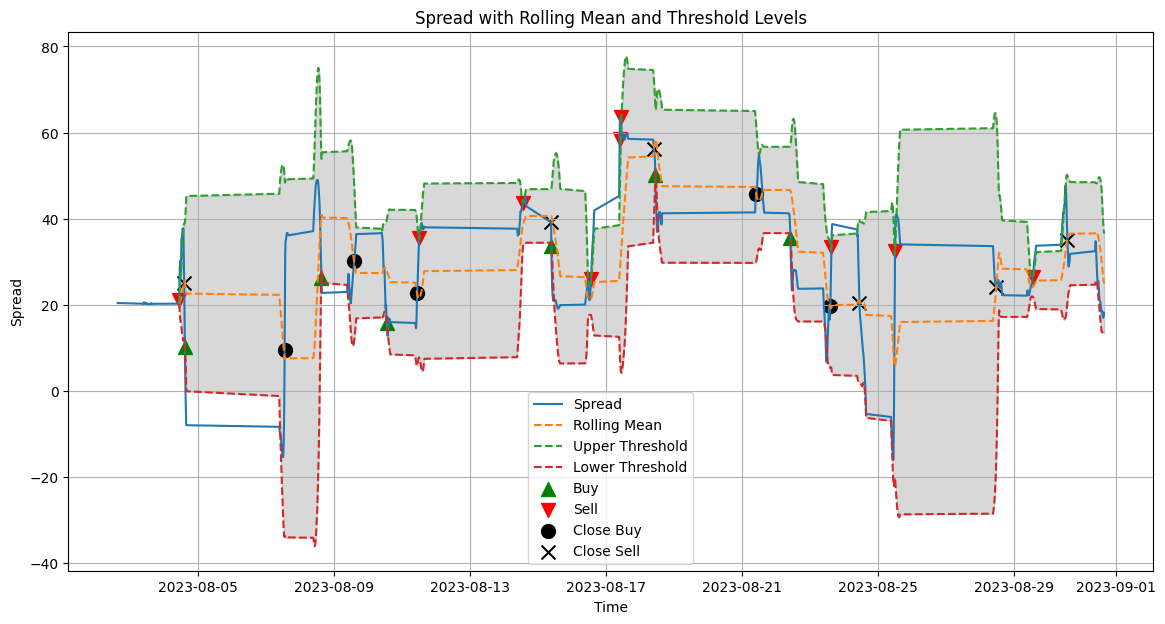

Trade Metrics:
Average Trade Return: 4.732544587749144
Standard Deviation of Trade Returns: 20.018810746923812
Sharpe Ratio: 3.752811155267949
Cumulative Return: 0.02706004616033364


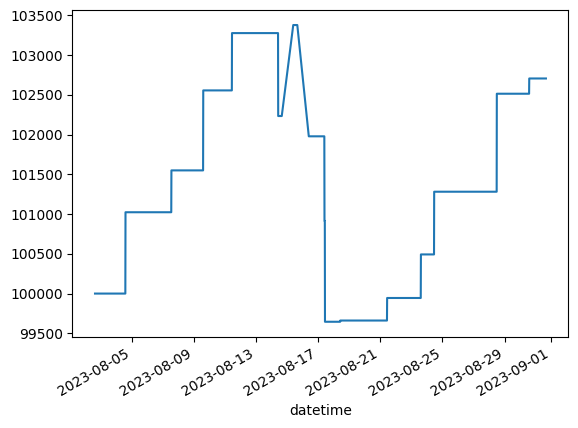

Clustering for 8 2023
DBSCAN(eps=1.5, min_samples=3)

Clusters discovered: 1
0 ('AAL', 'META')


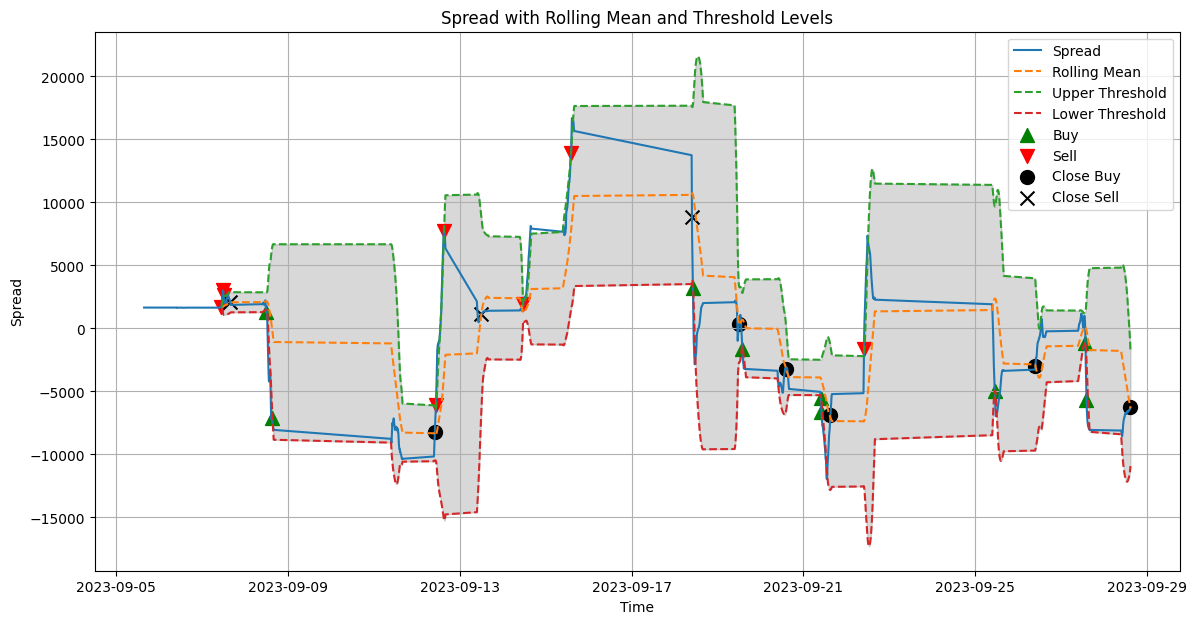

Trade Metrics:
Average Trade Return: -0.21208024222766048
Standard Deviation of Trade Returns: 0.43178595289545213
Sharpe Ratio: -7.797079666377058
Cumulative Return: -0.05455709036866396


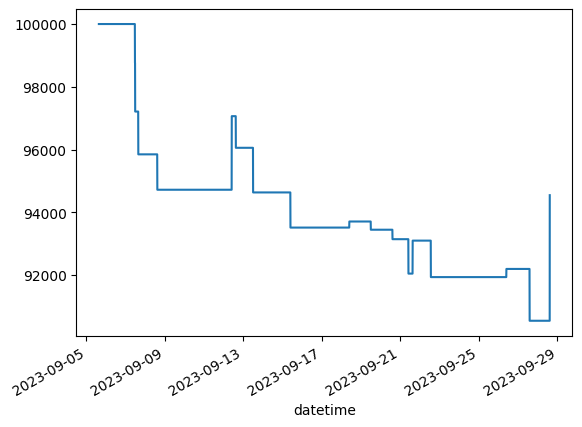

1 ('T', 'MSFT')


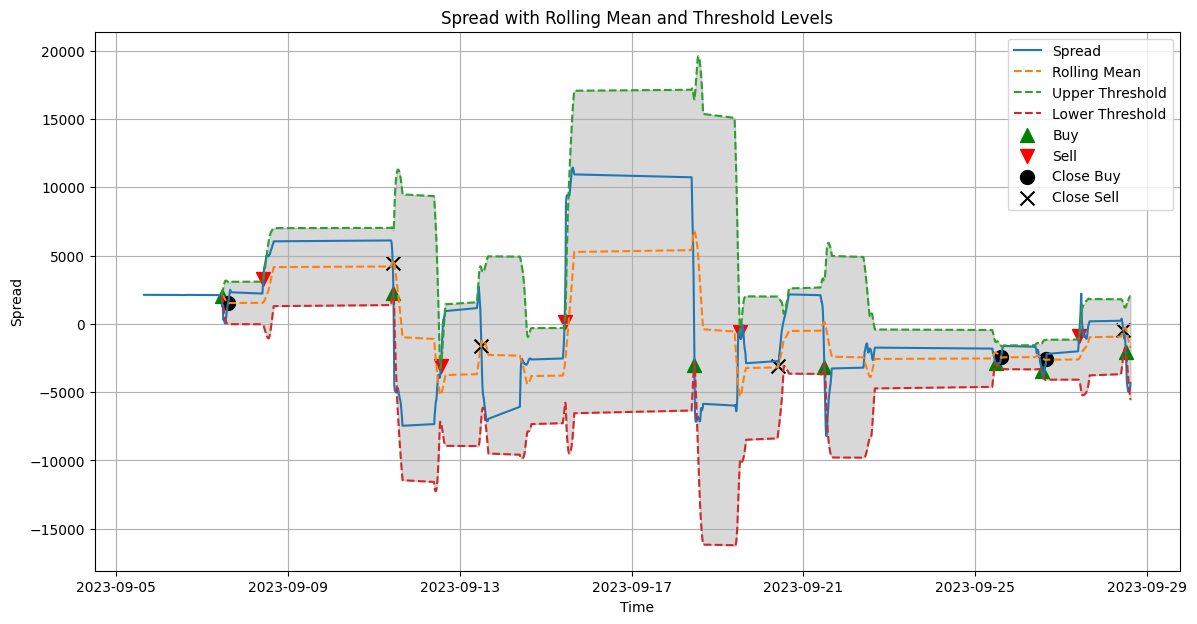

Trade Metrics:
Average Trade Return: -0.1931124227625923
Standard Deviation of Trade Returns: 0.16912725265151768
Sharpe Ratio: -18.125787690517537
Cumulative Return: -0.08135452330538306


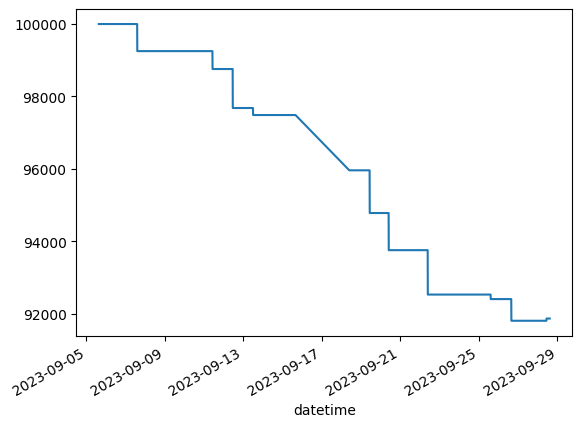

2 ('DAL', 'META')


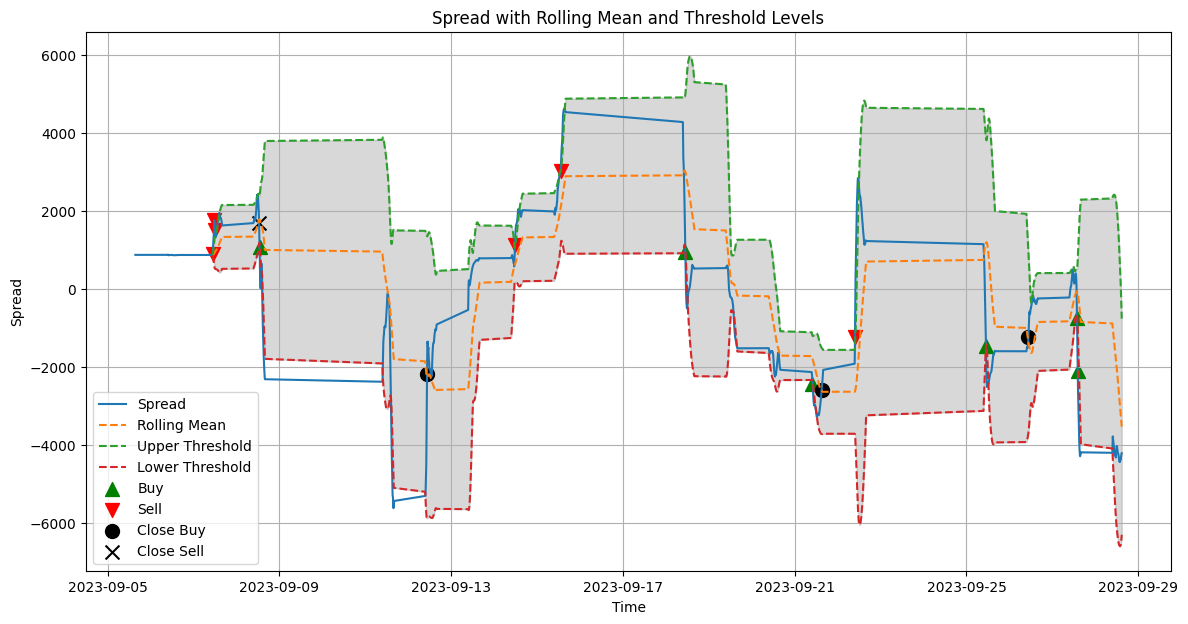

Trade Metrics:
Average Trade Return: -0.40013668057442975
Standard Deviation of Trade Returns: 0.5940807393498376
Sharpe Ratio: -10.692103720380818
Cumulative Return: -0.07797399046335374


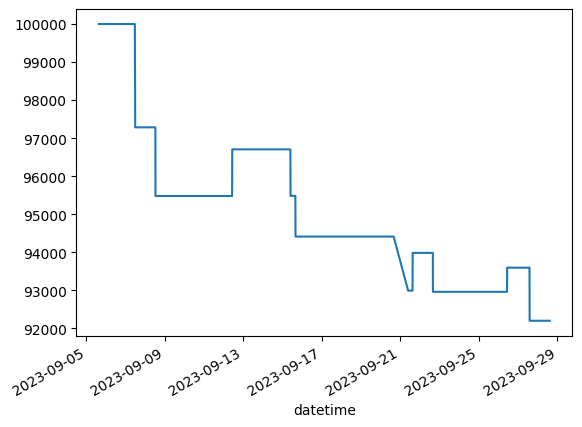

3 ('DAL', 'NKE')


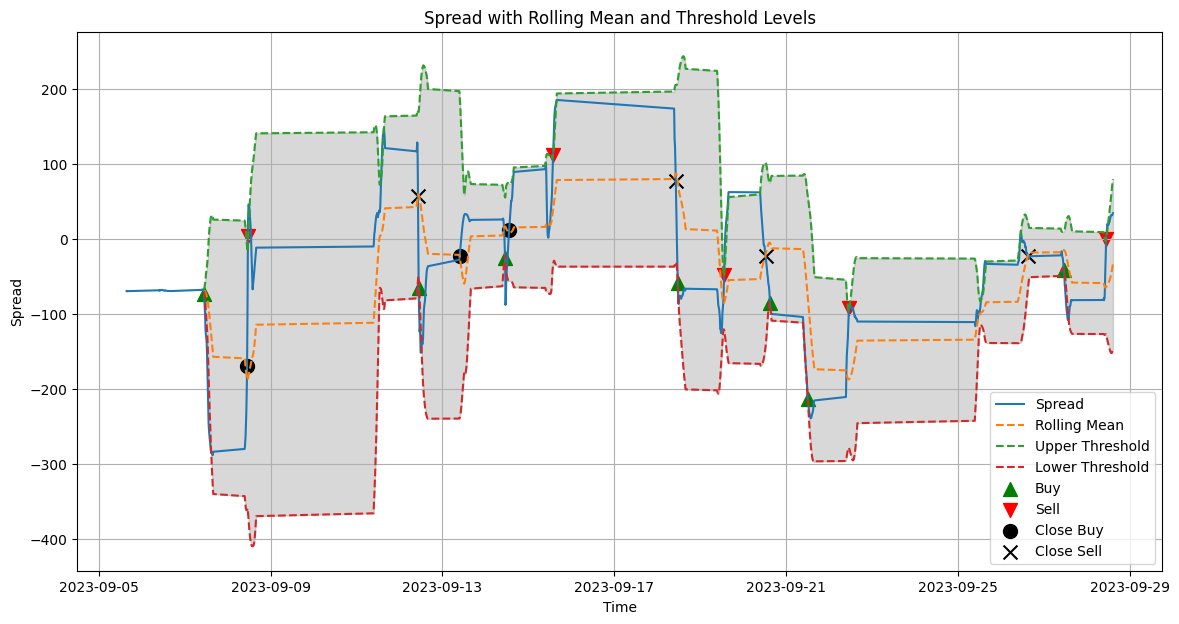

Trade Metrics:
Average Trade Return: 1.9655935404571516
Standard Deviation of Trade Returns: 11.217952568350519
Sharpe Ratio: 2.781508473136256
Cumulative Return: -0.01273184227541957


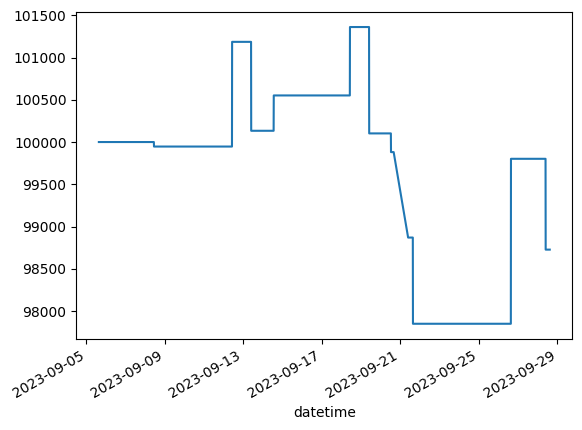

4 ('DAL', 'PFE')


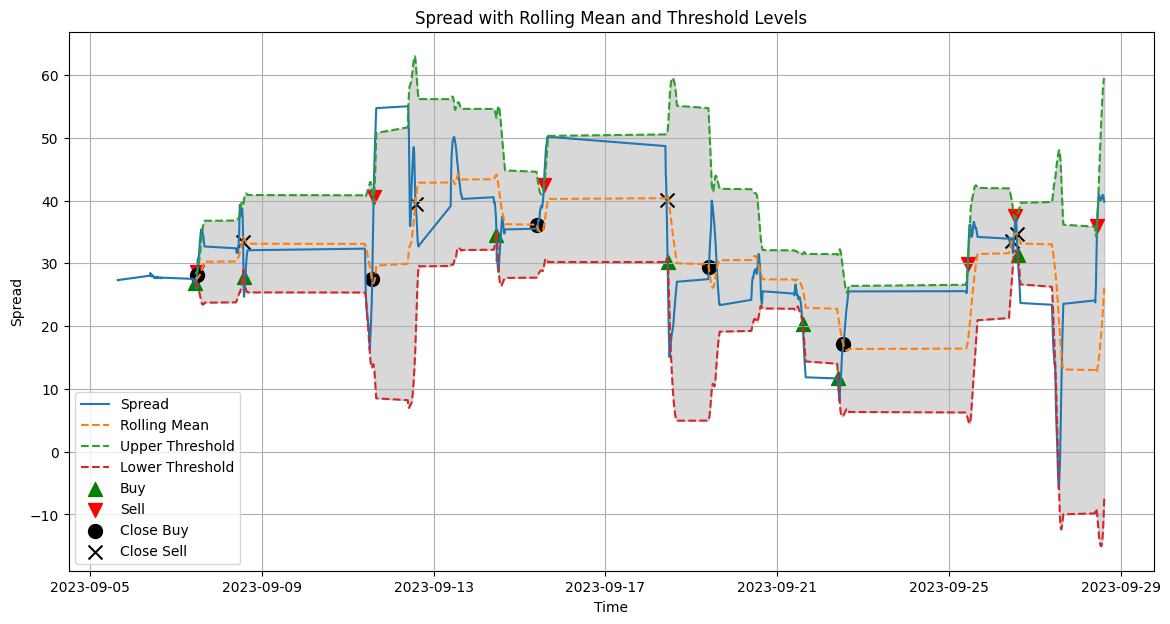

Trade Metrics:
Average Trade Return: 0.9198540318929357
Standard Deviation of Trade Returns: 13.574084872133572
Sharpe Ratio: 1.075743241829129
Cumulative Return: -0.006488300155205962


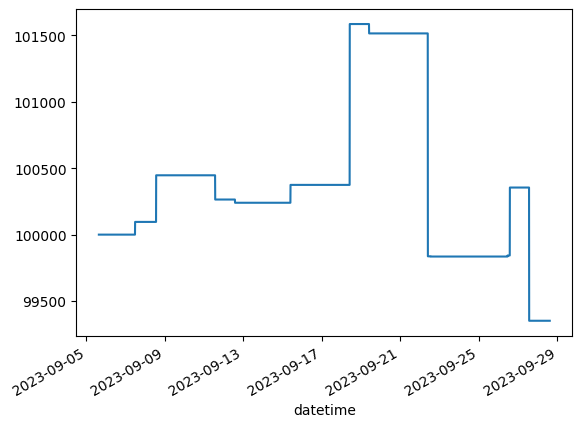

5 ('DAL', 'WBA')


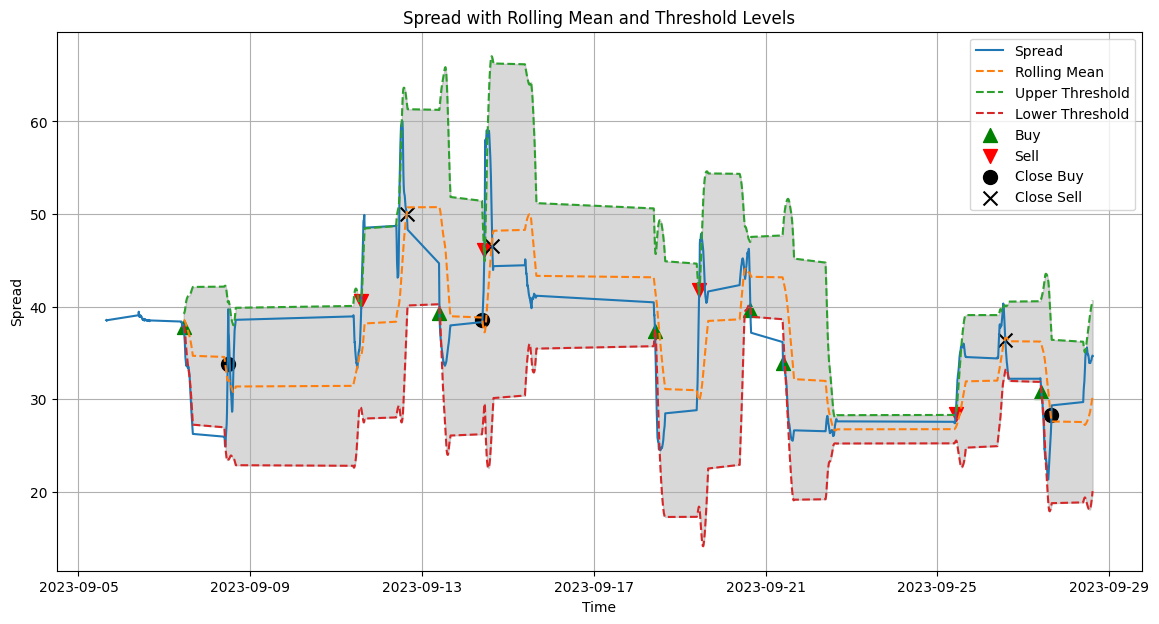

Trade Metrics:
Average Trade Return: -8.32895551384898
Standard Deviation of Trade Returns: 19.22683109894703
Sharpe Ratio: -6.876747870876576
Cumulative Return: -0.040702752507405626


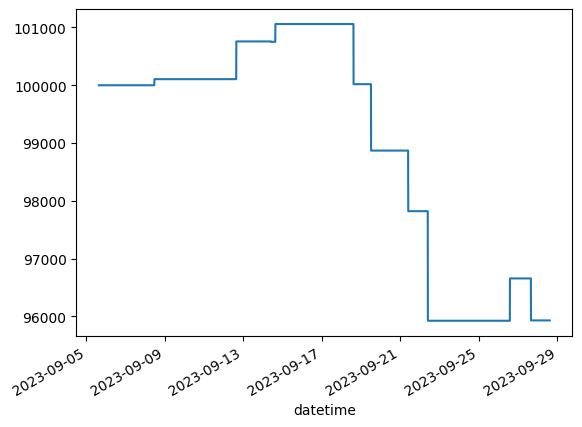

6 ('META', 'MSFT')


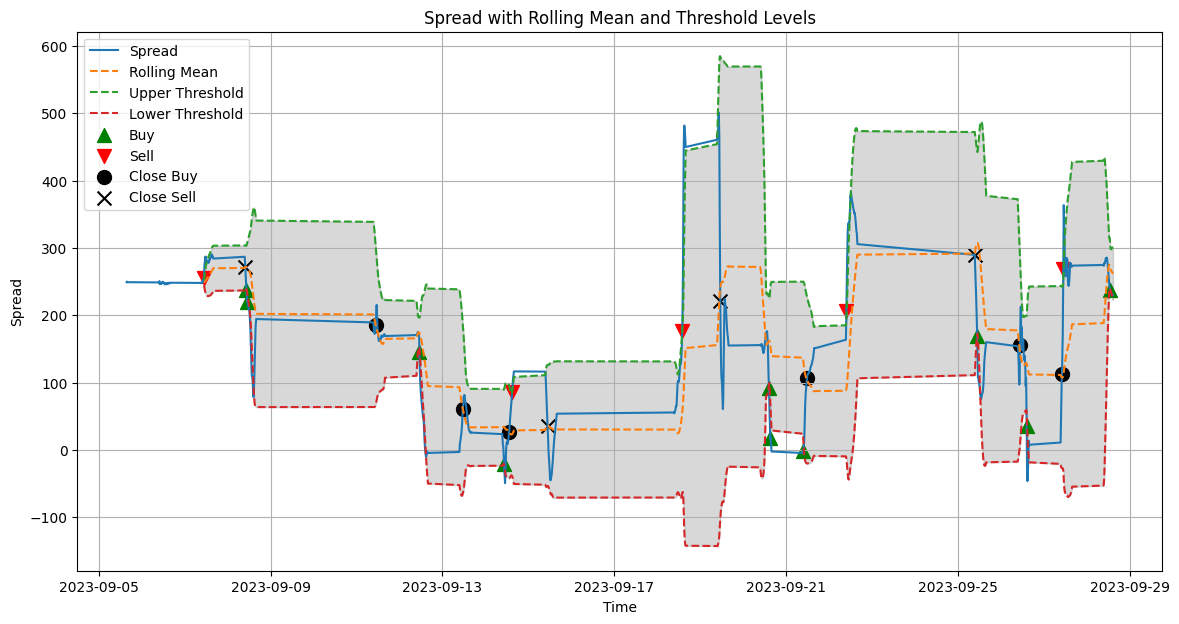

Trade Metrics:
Average Trade Return: 0.8469961369960436
Standard Deviation of Trade Returns: 2.9629423583929113
Sharpe Ratio: 4.537937365354763
Cumulative Return: 0.04697284314890782


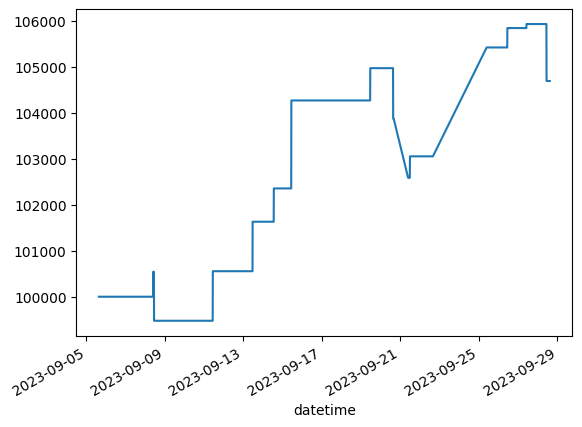

7 ('META', 'NKE')


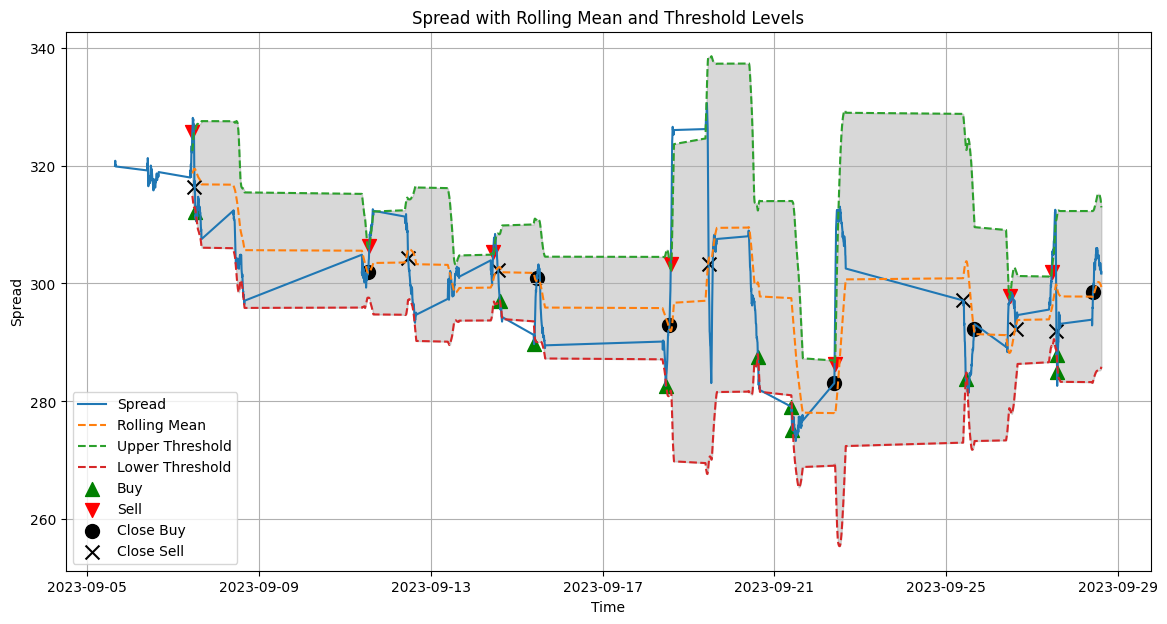

Trade Metrics:
Average Trade Return: 3.039310278207086
Standard Deviation of Trade Returns: 5.82680963526039
Sharpe Ratio: 8.280269639808614
Cumulative Return: 0.15748898091116392


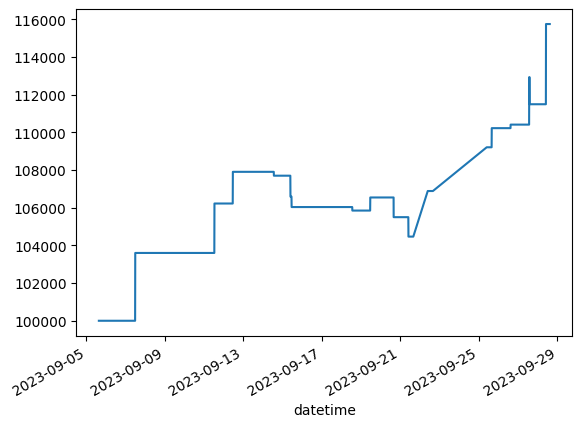

8 ('META', 'PFE')


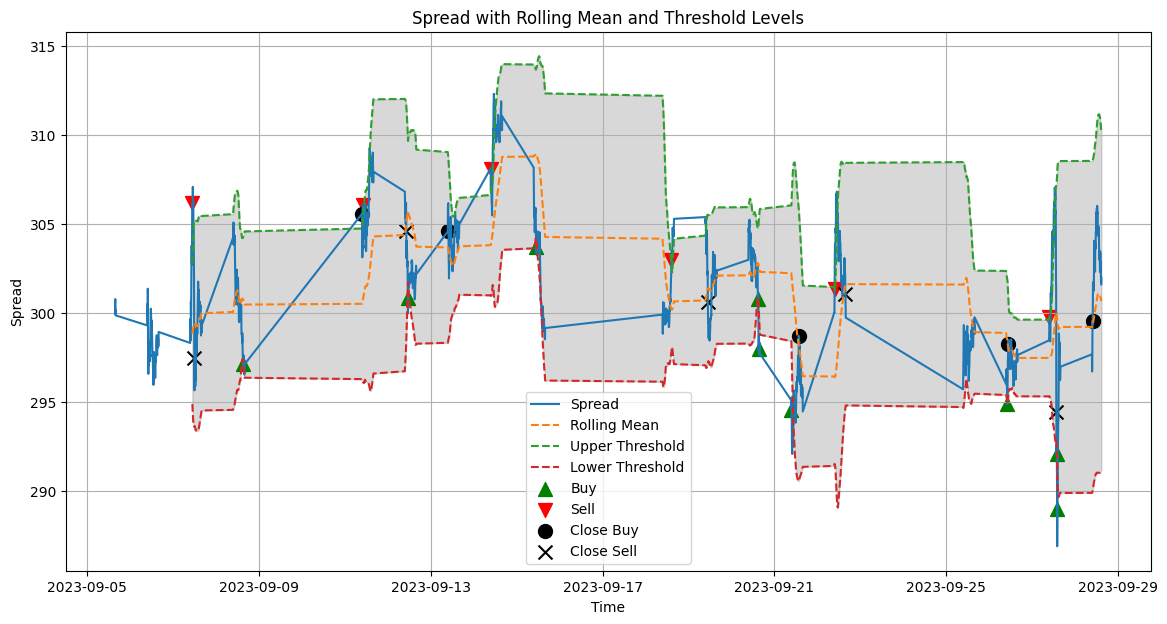

Trade Metrics:
Average Trade Return: 2.60318651627976
Standard Deviation of Trade Returns: 5.700553386784271
Sharpe Ratio: 7.249174251426214
Cumulative Return: 0.11750985774099165


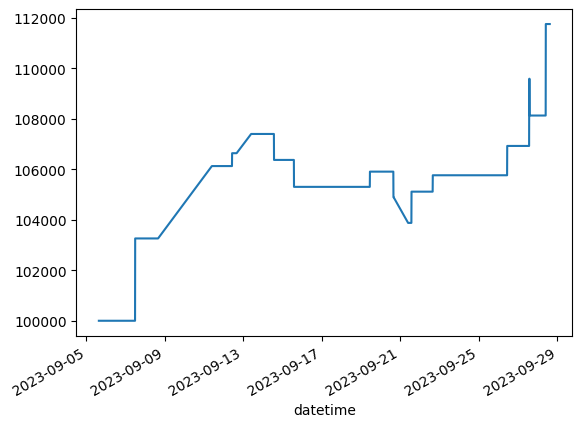

9 ('META', 'TGT')


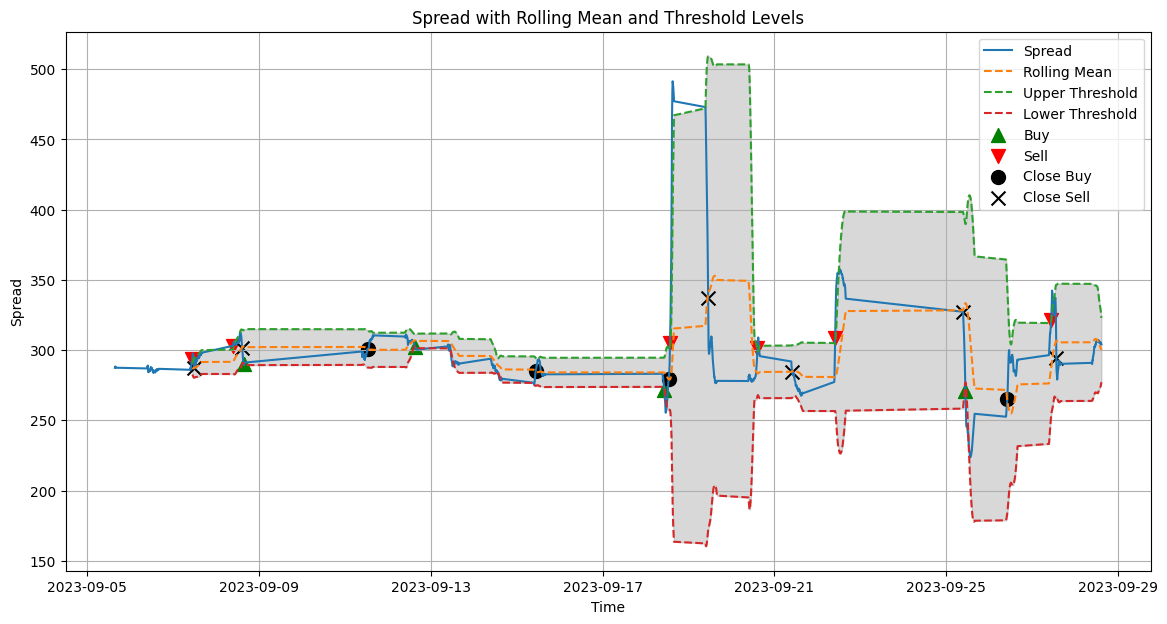

Trade Metrics:
Average Trade Return: 5.961970228830543
Standard Deviation of Trade Returns: 4.310983364173081
Sharpe Ratio: 21.9540033680675
Cumulative Return: 0.18373125455648687


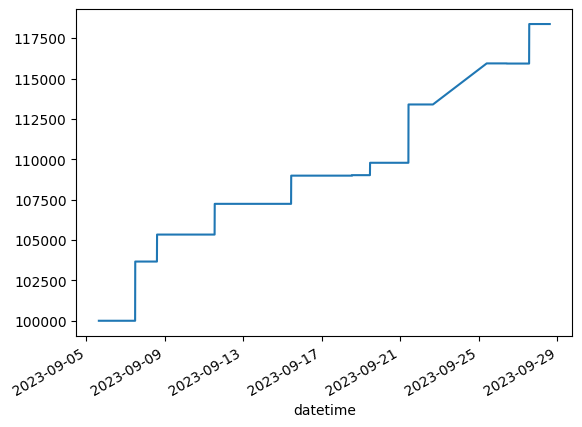

Clustering for 9 2023
DBSCAN(eps=1.5, min_samples=3)

Clusters discovered: 5


ValueError: zero-size array to reduction operation maximum which has no identity

In [10]:
data = prices[-15000:-5000]

# prepare data
for year, month, monthly_data in yield_monthly_data(data):
    print(f"Clustering for {month} {year}")
    cluster = calculate_monthly_clusters(monthly_data)
    data = data.dropna(axis=1)
    next_month_data = generate_trading_data_blocks(data, month, year)

    #get pairs on first 500 data points
    pairs = get_coint_pairs(next_month_data[:500], cluster)


    for i,pair in zip(range(min(len(pairs[:10]),len(pairs))),pairs):
      print(i,pair)

      # df = process_pair(pair, next_month_data[150:])
      agent = TradingAgent()

      result_df = agent.process_pair(pair, next_month_data[150:])
      result_df = agent.trade(result_df)
      agent.visualize_spread(result_df)
      (result_df["capital"]).plot()
      metrics = agent.calculate_metrics(result_df)

      print("Trade Metrics:")
      for key, value in metrics.items():
          print(f"{key}: {value}")
      plt.show()

      # input("yes")



      # trade these pairs using the df



In [ ]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt

class TradingAgent:
    def __init__(self, initial_capital=100000):
        self.initial_capital = initial_capital
        self.per_pair_capital = initial_capital

    def calculate_hedge_ratio(self, x, y):
        x = sm.add_constant(x)  # Adding a constant term for the intercept
        model = sm.OLS(y, x).fit()
        return model.params[1]  # Return the coefficient of x, which is the hedge ratio


    def process_pair(self, pair, prices, window=100):
        s1, s2 = pair
        datax = prices[s1]
        datay = prices[s2]

        hedge_ratios = []
        for start in range(len(datax) - window + 1):
            end = start + window
            x_window = datax[start:end]
            y_window = datay[start:end]
            hedge_ratio = self.calculate_hedge_ratio(x_window, y_window)
            hedge_ratios.append(hedge_ratio)

        hedge_ratios = pd.Series(hedge_ratios, index=datax.index[window-1:])
        hedge_ratios = hedge_ratios.reindex(datax.index).fillna(method='bfill')

        spread = datax - hedge_ratios * datay
        rolling_mean = spread.rolling(window=window).mean()
        rolling_std = spread.rolling(window=window).std()
        upper_threshold_level = rolling_mean + 2 * rolling_std
        lower_threshold_level = rolling_mean - 2 * rolling_std

        result_df = pd.DataFrame({
            's1': datax,
            's2': datay,
            'spread': spread,
            'hedge_ratios': hedge_ratios,
            'rolling_mean': rolling_mean,
            'upper_threshold_level': upper_threshold_level,
            'lower_threshold_level': lower_threshold_level
        })

        result_df['returns'] = np.nan
        result_df['capital'] = self.initial_capital
        result_df['action'] = np.nan

        return result_df


    def trade(self, result_df):
        capital = self.initial_capital
        positions = 0
        entry_spread = 0
        entry_s1 = 0
        entry_s2 = 0
        last_capital_update_index = 0

        result_df['returns'] = 0.0
        result_df['capital'] = capital
        result_df['cap_ret'] = 0.0

        for i in range(1, len(result_df)):  # Start from the second row
            # Update capital for all rows till the current row
            if i > last_capital_update_index:
                result_df.loc[result_df.index[last_capital_update_index:i], 'capital'] = capital

            # Calculate the required capital to trade one pair
            required_capital_per_pair = (result_df['s1'].iloc[i] + abs(result_df['hedge_ratios'].iloc[i]) * result_df['s2'].iloc[i])

            # Calculate the maximum quantity that can be traded based on available capital
            max_qty = self.per_pair_capital // required_capital_per_pair

            if positions == 0:
                if result_df['spread'].iloc[i] > result_df['upper_threshold_level'].iloc[i]:
                    positions = -1  # Sell position
                    entry_spread = result_df['spread'].iloc[i]
                    entry_s1 = result_df['s1'].iloc[i]
                    entry_s2 = result_df['s2'].iloc[i]
                    entry_qty = max_qty
                    result_df.at[result_df.index[i], 'action'] = 'Sell'
                    last_capital_update_index = i
                elif result_df['spread'].iloc[i] < result_df['lower_threshold_level'].iloc[i]:
                    positions = 1  # Buy position
                    entry_spread = result_df['spread'].iloc[i]
                    entry_s1 = result_df['s1'].iloc[i]
                    entry_s2 = result_df['s2'].iloc[i]
                    entry_qty = max_qty
                    result_df.at[result_df.index[i], 'action'] = 'Buy'
                    last_capital_update_index = i

            elif positions == -1:
                if result_df['spread'].iloc[i] <= result_df['rolling_mean'].iloc[i]:
                    # Calculate percentage change in spread
                    spread_pct_change = (entry_spread - result_df['spread'].iloc[i]) / entry_spread
                    returns = entry_qty * required_capital_per_pair * spread_pct_change
                    capital += returns
                    result_df.at[result_df.index[i], 'returns'] = returns
                    result_df.at[result_df.index[i], 'capital'] = capital
                    result_df.at[result_df.index[i], 'action'] = 'Close Sell'
                    positions = 0  # Close position
                    last_capital_update_index = i

            elif positions == 1:
                if result_df['spread'].iloc[i] >= result_df['rolling_mean'].iloc[i]:
                    # Calculate percentage change in spread
                    spread_pct_change = (result_df['spread'].iloc[i] - entry_spread) / entry_spread
                    returns = entry_qty * required_capital_per_pair * spread_pct_change
                    capital += returns
                    result_df.at[result_df.index[i], 'returns'] = returns
                    result_df.at[result_df.index[i], 'capital'] = capital
                    result_df.at[result_df.index[i], 'action'] = 'Close Buy'
                    positions = 0  # Close position
                    last_capital_update_index = i

        # Update capital for the remaining rows
        result_df.loc[result_df.index[last_capital_update_index:], 'capital'] = capital

        # Calculate cumulative return on initial capital
        result_df['cap_ret'] = result_df['capital'] / self.initial_capital - 1

        return result_df


    def visualize_spread(self, result_df):
        plt.figure(figsize=(14, 7))

        result_df.reset_index(inplace=True)

        plt.plot(result_df.index, result_df['spread'], label='Spread')
        plt.plot(result_df.index, result_df['rolling_mean'], label='Rolling Mean', linestyle='--')
        plt.plot(result_df.index, result_df['upper_threshold_level'], label='Upper Threshold', linestyle='--')
        plt.plot(result_df.index, result_df['lower_threshold_level'], label='Lower Threshold', linestyle='--')

        plt.fill_between(result_df.index, 2, -2, color='grey', alpha=0.3)

        # Add markers for actions
        buys = result_df[result_df['action'] == 'Buy']
        sells = result_df[result_df['action'] == 'Sell']
        close_buys = result_df[result_df['action'] == 'Close Buy']
        close_sells = result_df[result_df['action'] == 'Close Sell']

        plt.scatter(buys.index, buys['spread'], color='green', marker='^', s=100, label='Buy')
        plt.scatter(sells.index, sells['spread'], color='red', marker='v', s=100, label='Sell')
        plt.scatter(close_buys.index, close_buys['spread'], color='black', marker='o', s=100, label='Close Buy')
        plt.scatter(close_sells.index, close_sells['spread'], color='black', marker='x', s=100, label='Close Sell')

        plt.title('Spread with Rolling Mean and Threshold Levels')
        plt.xlabel('Time')
        plt.ylabel('Spread')
        plt.legend()
        plt.grid(True)
        plt.show()
